# Context Offloading

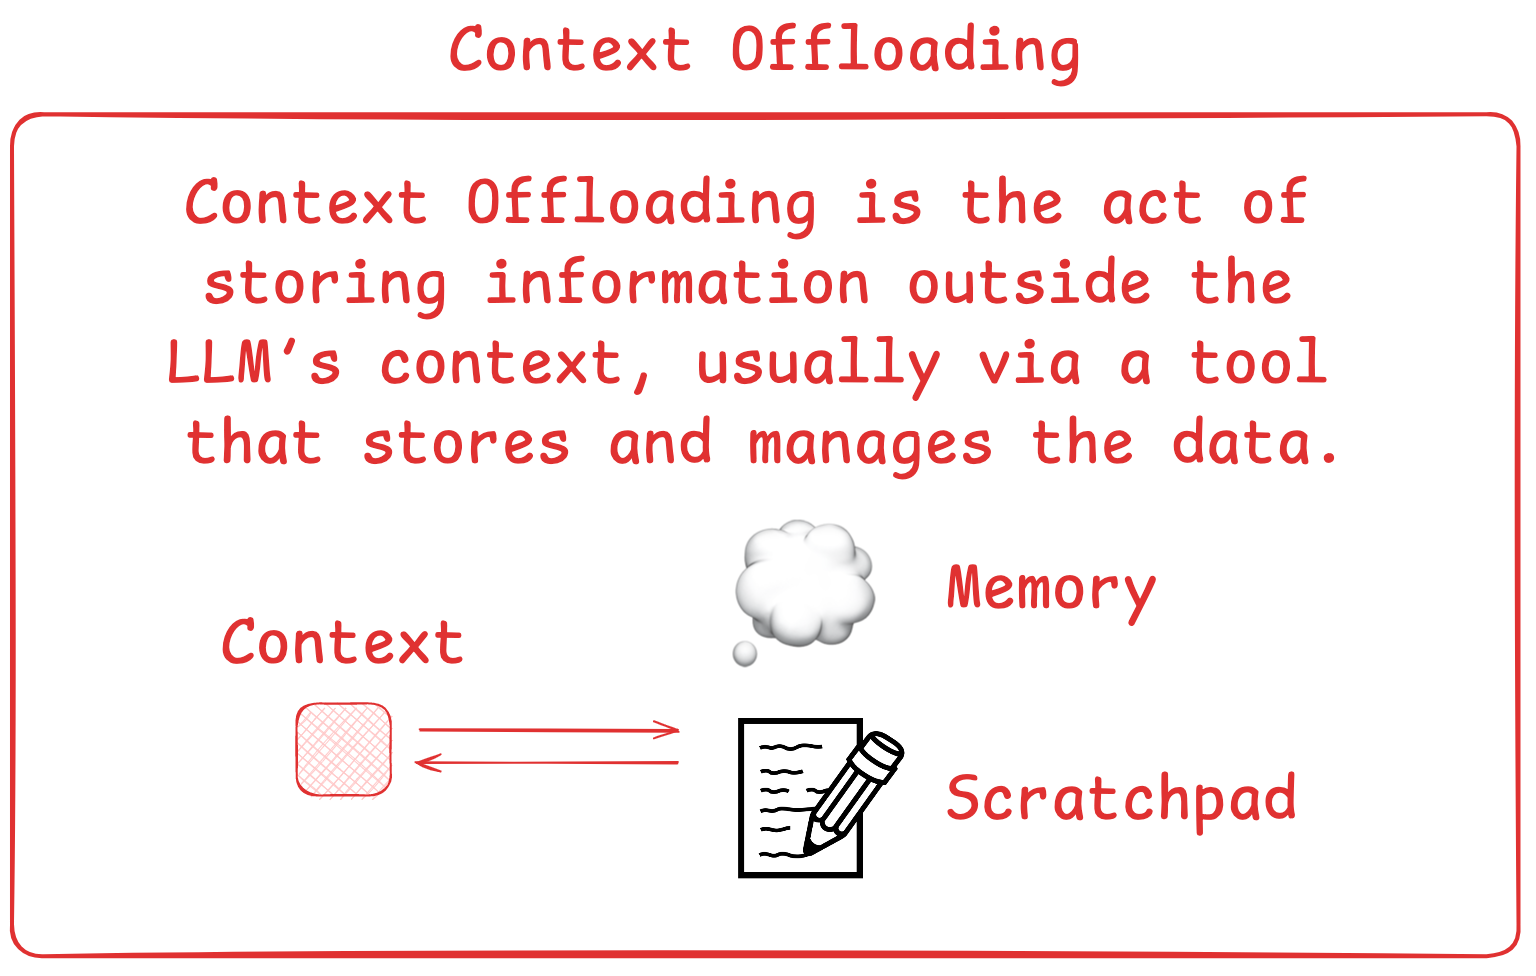

## What is it

*Context Offloading is the act of storing information outside the LLM’s context, usually via a tool that stores and manages the data.*

## Why it helps

* Avoids Context Rot: [Chroma’s experiments outline the problem of Context Rot](https://research.trychroma.com/context-rot). As you bury information information deeper into the context window, model accuracy on even simple retrieval or reasoning tasks degrades in non‑uniform and often surprising ways. So, if you want to re-use a piece of context it is often useful to offload it, store it outside of the context window, and then select it later as needed (e.g., via RAG).

## Context Offloading in Practice

When humans solve tasks, we take notes and remember things for future, related tasks. Agents are also gaining these capabilities! Drew's post highlights Anthropic's research on note-taking via a "[think tool](https://www.anthropic.com/engineering/claude-think-tool)". [Anthropic's multi-agent researcher](https://www.anthropic.com/engineering/built-multi-agent-research-system) makes explicit use of a scratchpad to persist the research plan outside of the context window so that it's available to the agent on-demand:

> The LeadResearcher begins by thinking through the approach and saving its plan to Memory to persist the context, since if the context window exceeds 200,000 tokens it will be truncated and it is important to retain the plan.

[Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) also performs context offloading to the file system. They mention this is highly useful to store token-heavy tool calls. They also mention that initially Manus writes a plan (e.g., to a `todo.md` file) and re-writes it during agent execution. This forces Manus to recite its objectives into the end of the context window.

It's worth noting that this context offloading can be implemented in a few different ways. A scratchpad can just be a field in a runtime [state object](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) that persists during the agent's runtime. It could also be a [tool call](https://www.anthropic.com/engineering/claude-think-tool) that [writes to a file](https://github.com/modelcontextprotocol/servers/tree/main/src/filesystem). 

Scratchpads help agents solve a task within a given agent-user interactions, but sometimes agents benefit from remembering things across *many* interactions! [Reflexion](https://arxiv.org/abs/2303.11366) introduced the idea of reflection following each agent turn and re-using these self-generated hints. [Generative Agents](https://ar5iv.labs.arxiv.org/html/2304.03442) created memories synthesized periodically from collections of past agent feedback.

In these cases, context is often stored as a "memory" that can be accessed across many user-agent interactions. These concepts made their way into popular products like [ChatGPT](https://help.openai.com/en/articles/8590148-memory-faq), [Cursor](https://forum.cursor.com/t/0-51-memories-feature/98509), and [Windsurf](https://docs.windsurf.com/windsurf/cascade/memories), which all have mechanisms to auto-generate long-term memories based on user-agent interactions.

In all cases, the intuition is clear: context offloading lets agents save useful information during a session to help them accomplish tasks.

### Context Offloading via LangGraph state object

LangGraph is designed around a [state object](https://langchain-ai.github.io/langgraph/concepts/low_level/#state). The state object in LangGraph serves as the central data structure that gets passed between nodes in your graph. This is useful as s "scratchpad", allowing you to write information to state at any point during agent execution and fetch it later as needed. Let's show how to use it!

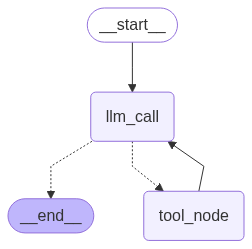

In [9]:
# Import organization: Standard library, then third-party packages
import getpass
import os
from typing_extensions import Literal

# Jupyter and display utilities  
from IPython.display import Image, display

# Pydantic for data modeling
from pydantic import BaseModel, Field

# LangChain core components
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_tavily import TavilySearch

# LangGraph components for workflow and state management
from langgraph.graph import END, START, StateGraph, MessagesState

def _set_env(var: str) -> None:
    """Set environment variable if not already set.
    
    Args:
        var: Environment variable name to set
    """
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# Extended state class to include scratchpad functionality
class ScratchpadState(MessagesState):
    """State that extends MessagesState to include a scratchpad field.
    
    The scratchpad provides temporary storage during agent execution,
    allowing information to persist within a single conversation thread.
    """
    scratchpad: str = Field(description="The scratchpad for storing notes")

_set_env("ANTHROPIC_API_KEY")
_set_env("TAVILY_API_KEY")

# Scratchpad management tools
@tool
class WriteToScratchpad(BaseModel):
    """Save notes to the scratchpad for future reference within the conversation."""
    notes: str = Field(description="Notes to save to the scratchpad")

@tool  
class ReadFromScratchpad(BaseModel):
    """Read previously saved notes from the scratchpad."""
    reasoning: str = Field(description="Reasoning for fetching notes from the scratchpad")

search_tool = TavilySearch(
    max_results=5,
    topic="general",
)

# Initialize the language model
llm = init_chat_model("anthropic:claude-sonnet-4-20250514", temperature=0)

# Configure scratchpad tools
tools = [ReadFromScratchpad, WriteToScratchpad, search_tool]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

# Enhanced research planning prompt with structured workflow
scratchpad_prompt = """You are a sophisticated research assistant with access to web search and a persistent scratchpad for note-taking.

Your Research Workflow:
1. **Check Scratchpad**: Before starting a new research task, check your scratchpad to see if you have any relevant information already saved and use this to help write your research plan
2. **Create Research Plan**: Create a structured research plan
3. **Write to Scratchpad**: Save the research plan and any important information to your scratchpad
4. **Use Search**: Gather information using web search to address each aspect of your research plan
5. **Update Scratchpad**: After each search, update your scratchpad with new findings and insights
5. **Iterate**: Repeat searching and updating until you have comprehensive information
6. **Complete Task**: Provide a thorough response based on your accumulated research

Tools Available:
- WriteToScratchpad: Save research plans, findings, and progress updates
- ReadFromScratchpad: Retrieve previous research work and notes
- TavilySearch: Search the web for current information

Always maintain organized notes in your scratchpad and build upon previous research systematically."""

def llm_call(state: ScratchpadState) -> dict:
    """Execute LLM call with system prompt and conversation history.
    
    Args:
        state: Current conversation state
        
    Returns:
        Dictionary with LLM response
    """
    return {
        "messages": [
            llm_with_tools.invoke(
                [SystemMessage(content=scratchpad_prompt)] + state["messages"]
            )
        ]
    }
    
def tool_node(state: ScratchpadState) -> dict:
    """Execute tool calls and manage scratchpad state updates.
    
    Handles both reading from and writing to the scratchpad, updating
    the conversation state accordingly.
    
    Args:
        state: Current conversation state with tool calls
        
    Returns:
        Dictionary with tool results and updated state
    """
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        if tool_call["name"] == "WriteToScratchpad":
            # Save notes to scratchpad and update state
            notes = observation.notes
            result.append(ToolMessage(content=f"Wrote to scratchpad: {notes}", tool_call_id=tool_call["id"]))
            update = {"messages": result, "scratchpad": notes}
        elif tool_call["name"] == "ReadFromScratchpad":
            # Retrieve notes from scratchpad state
            notes = state.get("scratchpad", "")
            result.append(ToolMessage(content=f"Notes from scratchpad: {notes}", tool_call_id=tool_call["id"]))
            update = {"messages": result}
        elif tool_call["name"] == "tavily_search":
            # Write search tool observation to messages
            result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
            update = {"messages": result}
    return update

def should_continue(state: ScratchpadState) -> Literal["tool_node", "__end__"]:
    """Determine workflow continuation based on tool calls.
    
    Args:
        state: Current conversation state
        
    Returns:
        Next node name or END
    """
    messages = state["messages"]
    last_message = messages[-1]
    return "tool_node" if last_message.tool_calls else END

# Build the scratchpad-enabled workflow
agent_builder = StateGraph(ScratchpadState)

# Add workflow nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Define workflow edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges("llm_call", should_continue, {"tool_node": "tool_node", END: END})
agent_builder.add_edge("tool_node", "llm_call")
agent = agent_builder.compile()

# Display the workflow graph
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [10]:
# Research request 
from langchain_core.messages import HumanMessage
query = "Comparae the funding rounds and recent developments of Commonwealth Fusion Systems vs Helion Energy."
state = agent.invoke({"messages": [HumanMessage(content=query)]})

from utils import format_messages
format_messages(state['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Comparae the funding rounds and recent developments of Commonwealth Fusion Systems vs Helion Energy.            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you compare the funding rounds and recent developments of Commonwealth Fusion Systems vs Helion       │
│ Energy. Let me start by checking my scratchpad and then creating a research plan.                               │
│                                                                                                                 │
│ 🔧 Tool Call: ReadFromScratchpad                                                                                │
│    Args: {                                                                                                      │
│   "reasoning": "Checking if I have any previous research on Commonwealth Fusion Systems or Helion Energy to     │
│ build upon"                                                                                                     │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Notes from scratchpad:                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me create a research plan and begin gathering information on both companies.                            │
│                                                                                                                 │
│ 🔧 Tool Call: WriteToScratchpad                                                                                 │
│    Args: {                                                                                                      │
│   "notes": "RESEARCH PLAN: Commonwealth Fusion Systems vs Helion Energy Comparison\n\nKey Areas to              │
│ Research:\n1. Commonwealth Fusion Systems (CFS):\n   - Recent funding rounds (amounts, dates, investors)\n   -  │
│ Latest technological developments\n   - Recent milestones and announcements\n   - Current valuation and         │
│ business status\n\n2. Helion Energy:\n   - Recent funding rounds (amounts, dates, investors)\n   - Latest       │
│ technological developments\n   - Recent milestones and announcements\n   - Current valuation and business       │
│ status\n\n3. Comparative Analysis:\n   - Funding comparison (total raised, recent rounds)\n   - Technology      │
│ approaches\n   - Timeline to commercialization\n   - Key partnerships and developments\n\nStarting research..." │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: RESEARCH PLAN: Commonwealth Fusion Systems vs Helion Energy Comparison                     │
│                                                                                                                 │
│ Key Areas to Research:                                                                                          │
│ 1. Commonwealth Fusion Systems (CFS):                                                                           │
│    - Recent funding rounds (amounts, dates, investors)                                                          │
│    - Latest technological developments                                                                          │
│    - Recent milestones and announcements                                                                        │
│    - Current valuation and business status                                                                      │
│                                                                                                                 │
│ 2. Helion Energy:                                                                                               │
│    - Recent funding rounds (amounts, dates, investors)                                                          │
│    - Latest technological developments                                                                          │
│    - Recent milestones and announcements                                                                        │
│    - Current valuation and business status                                                                      │
│                                                                                                                 │
│ 3. Comparative Analysis:                                                                                        │
│    - Funding comparison (total raised, recent rounds)                                                           │
│    - Technology approaches                                                                                      │
│    - Timeline to commercialization                                                                              │
│    - Key partnerships and developments                                                                          │
│                                                                                                                 │
│ Starting research...                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Commonwealth Fusion Systems funding rounds 2024 2023 recent investments",                           │
│   "search_depth": "advanced",                                                                                   │
│   "time_range": "year"                                                                                          │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Commonwealth Fusion Systems funding rounds 2024 2023 recent investments', 'follow_up_questions':     │
│ None, 'answer': None, 'images': [], 'results': [{'url':                                                         │
│ 'https://en.wikipedia.org/wiki/Commonwealth_Fusion_Systems', 'title': 'Commonwealth Fusion Systems -            │
│ Wikipedia', 'content': 'In May 2023, United States Department of Energy granted the company additional funding  │
│ along with seven other US companies via the Milestone-Based Fusion Development Program.', 'score': 0.54956865,  │
│ 'raw_content': None}, {'url': 'https://blog.cfs.energy/the-race-to-lead-the-world-in-fusion-has-begun/',        │
│ 'title': 'The race to lead the world in fusion has begun | The Tokamak Times', 'content': 'In 2023, by some     │
│ estimates the Chinese government’s fusion support was $1.5 billion — twice the DOE’s spending. This number is   │
│ likely very conservative. At the same time, investments in Chinese fusion companies have risen from zero in     │
│ 2021 to $1.3 billion in 2024, matching investments in US fusion companies, according to the Fusion Energy Base. │
│ [...] ## Fusion energy industry progress\n\nFor decades, fusion was largely an academic pursuit. Progress now   │
│ has brought commercialization within reach, with dozens of company efforts underway. Our effort at Commonwealth │
│ Fusion Systems (CFS) in Massachusetts is the most mature, securing more than $2 billion in funding and hiring   │
│ more than 1,000 employees. The US has the most fusion startups, with others headquartered in the UK, Germany,   │
│ Japan, China, and a few other countries. [...] Commonwealth Fusion Systems  \n117 Hospital Rd  \nDevens, MA     │
│ 01434  \n  \nCopyright; 2025 Commonwealth Fusion Systems  \nAll rights reserved.', 'score': 0.4526091,          │
│ 'raw_content': None}, {'url':                                                                                   │
│ 'https://cfs.energy/news-and-media/google-and-commonwealth-fusion-systems-sign-strategic-partnership/',         │
│ 'title': 'Google and Commonwealth Fusion Systems Sign Strategic ...', 'content': "Commonwealth Fusion Systems   │
│ \n117 Hospital Rd  \nDevens, MA 01434  \n  \nCopyright 2024 Commonwealth Fusion Systems  \nAll rights reserved  │
│ [...] About Google\n\nGoogle's mission is to organize the world's information and make it universally           │
│ accessible and useful. Through products and platforms like Search, Maps, Gmail, Android, Google Play, Google    │
│ Cloud, Chrome and YouTube, Google plays a meaningful role in the daily lives of billions of people and has      │
│ become one of the most widely-known companies in the world. Google is a subsidiary of Alphabet Inc.\n\nAbout    │
│ Commonwealth Fusion Systems [...] Commonwealth Fusion Systems\n\n# Google and Commonwealth Fusion Systems Sign  │
│ Strategic Partnership\n\nCommonwealth Fusion Systems' Tokamak Hall, the home of the SPARC fusion                │
│ machine\n\nMOUNTAIN VIEW, Calif., and DEVENS, Mass. (June 30, 2025) â\x80\x94 Google and Commonwealth Fusion    │
│ Systems (CFS) today announced a new global milestone, a bold partnership to develop, deploy and scale clean,    │
│ secure fusion power.", 'score': 0.4420348, 'raw_content': None}, {'url':                                        │
│ 'https://www.datacenterdynamics.com/en/news/commonwealth-fusion-systems-raises-more-than-1bn-backed-by-unnamed- │
│ hyperscale-data-center-developer-report/', 'title': 'Commonwealth Fusion Systems raises more than $1bn, backed  │
│ by ...', 'content': 'Commonwealth Fusion Systems raises more than $1bn, backed by unnamed hyperscale data       │
│ center developer - report. Fusion power or quantum computing - which will', 'score': 0.2773878, 'raw_content':  │
│ None}, {'url':                                         

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Commonwealth Fusion Systems $1 billion funding round 2024 Series B investors",                      │
│   "search_depth": "advanced"                                                                                    │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Commonwealth Fusion Systems $1 billion funding round 2024 Series B investors',                       │
│ 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':                                  │
│ 'https://www.reddit.com/r/fusion/comments/1km2g7h/commonwealth_fusion_systems_raising_1_billionplus/', 'title': │
│ 'Commonwealth Fusion Systems raising $1 billion-plus Series B2', 'content': 'Image 22: r/fusion icon r/fusion•4 │
│ mo. ago Image 23: A banner for the subreddit Image 24: r/fusion iconr/fusion \nDiscussion and news on           │
│ advancements in the field of nuclear fusion energy and related technologies.\n\n  \n\n31K Members Online    ### │
│ An Update from Commonwealth Fusion Systems (December 2024)  Image 25: r/fusion - An Update from Commonwealth    │
│ Fusion Systems (December 2024)youtu    74 upvotes ·18 comments [...] Update on StockTwits Growth Mission as of  │
│ 12/27/2024Image 92: r/KenduInu_Ecosystem icon r/KenduInu_Ecosystem•5 mo. ago Image 93: A banner for the         │
│ subreddit Image 94: r/KenduInu_Ecosystem iconr/KenduInu_Ecosystem \nKendu is the narrative, and you are the     │
│ catalyst. Become the main character in the rise of the ultimate memecoin ecosystem. Will you join the pack?\n\n │
│ \n\n5.6K Members Online    ### Update on StockTwits Growth Mission as of 12/27/2024    89 upvotes ·7 comments   │
│ [...] Promoted  Image 26: sidebar promoted post thumbnailGeneral Fusion lays off staff due to ‘unexpected and   │
│ urgent financing constraints’Image 27: r/fusion icon r/fusion•7 days ago Image 28: A banner for the subreddit   │
│ Image 29: r/fusion iconr/fusion \nDiscussion and news on advancements in the field of nuclear fusion energy and │
│ related technologies.', 'score': 0.82254606, 'raw_content': None}, {'url':                                      │
│ 'https://www.cfs.energy/news-and-media/commonwealth-fusion-systems-closes-1-8-billion-series-b-round', 'title': │
│ 'Commonwealth Fusion Systems Raises $1.8 Billion in Funding to ...', 'content': 'Commonwealth Fusion Systems    │
│ (CFS) announced it has closed on more than $1.8 billion in Series B funding to commercialize fusion energy.     │
│ This includes capital to construct, commission, and operate SPARC, the world’s first commercially relevant net  │
│ energy fusion machine. In addition, it will enable the company to begin work on ARC, the first commercial       │
│ fusion power plant, which includes developing support technologies, advancing the design, identifying the site, │
│ and assembling the partners and [...] The round was led by Tiger Global Management with participation by new    │
│ investors, including (in alphabetical order) Bill Gates; Coatue; DFJ Growth; Emerson Collective; Footprint      │
│ Coalition; Google; JIMCO Technology Fund, part of JIMCO, the Jameel Family’s global investment arm; John Doerr; │
│ JS Capital; Marc Benioff’s TIME Ventures; Senator Investment Group; a major university endowment; and a pension │
│ plan; as well as current investors, including Breakthrough Energy Ventures; The Engine; Eni; [...] #### Related │
│ Topics\n\nfundingcompany news\n\nJoin the power movement\n-----------------------\n\nFollow Us\n\n   Image 1\n  │
│ Image 2\n   Image 3\n   Image 4\n\nApply Now\n\n[](\nCommonwealth Fusion Systems\n\n117 Hospital Rd\n\nDevens,  │
│ MA 01434\n\nCopyright 2024 Commonwealth Fusion Systems\n\nAll rights reserved\n\nMedia &                        │
│ Press\n\npress@cfs.energyGeneral Inquiries\n\ninfo@cfs.energy\n\nJoin our mailing list\n\n   Company\n          │
│ Technology\n   Press Releases\n   Privacy Policy\n   Careers\n   Blog', 'score': 0.80442166, 'raw_content':     │
│ None}, {'url': 'https://www.linkedin.com/company/commonwealth-fusion-systems', 'title': 'Commonwealth Fusion    │
│ Systems | LinkedIn', 'content': "### Website\n\n### Cru

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: WriteToScratchpad                                                                                 │
│    Args: {                                                                                                      │
│   "notes": "RESEARCH FINDINGS - Commonwealth Fusion Systems:\n\nFUNDING:\n- Closed $1.8 billion Series B        │
│ funding round (announced 2024)\n- Led by Tiger Global Management\n- New investors include: Bill Gates, Google,  │
│ Coatue, DFJ Growth, Emerson Collective, Footprint Coalition, JIMCO Technology Fund, John Doerr, JS Capital,     │
│ Marc Benioff's TIME Ventures, Senator Investment Group, major university endowment, pension plan\n- Existing    │
│ investors: Breakthrough Energy Ventures, The Engine, Eni, others\n- Total funding: Over $2 billion secured\n-   │
│ Additional DOE grant funding in May 2023 via Milestone-Based Fusion Development Program\n- Recent reports       │
│ suggest additional $1+ billion raised in 2024/2025\n\nRECENT DEVELOPMENTS:\n- Google partnership announced June │
│ 30, 2025 - Google will buy half the output of CFS's first commercial power plant\n- Over 1,000 employees        │
│ hired\n- Building SPARC fusion machine (world's first commercially relevant net energy fusion machine)\n-       │
│ Planning ARC commercial fusion power plant\n- Company described as \"most mature\" fusion effort\n\nNext:       │
│ Research Helion Energy..."                                                                                      │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: RESEARCH FINDINGS - Commonwealth Fusion Systems:                                           │
│                                                                                                                 │
│ FUNDING:                                                                                                        │
│ - Closed $1.8 billion Series B funding round (announced 2024)                                                   │
│ - Led by Tiger Global Management                                                                                │
│ - New investors include: Bill Gates, Google, Coatue, DFJ Growth, Emerson Collective, Footprint Coalition, JIMCO │
│ Technology Fund, John Doerr, JS Capital, Marc Benioff's TIME Ventures, Senator Investment Group, major          │
│ university endowment, pension plan                                                                              │
│ - Existing investors: Breakthrough Energy Ventures, The Engine, Eni, others                                     │
│ - Total funding: Over $2 billion secured                                                                        │
│ - Additional DOE grant funding in May 2023 via Milestone-Based Fusion Development Program                       │
│ - Recent reports suggest additional $1+ billion raised in 2024/2025                                             │
│                                                                                                                 │
│ RECENT DEVELOPMENTS:                                                                                            │
│ - Google partnership announced June 30, 2025 - Google will buy half the output of CFS's first commercial power  │
│ plant                                                                                                           │
│ - Over 1,000 employees hired                                                                                    │
│ - Building SPARC fusion machine (world's first commercially relevant net energy fusion machine)                 │
│ - Planning ARC commercial fusion power plant                                                                    │
│ - Company described as "most mature" fusion effort                                                              │
│                                                                                                                 │
│ Next: Research Helion Energy...                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Helion Energy funding rounds 2024 2023 recent investments Series C",                                │
│   "search_depth": "advanced",                                                                                   │
│   "time_range": "year"                                                                                          │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Helion Energy funding rounds 2024 2023 recent investments Series C', 'follow_up_questions': None,    │
│ 'answer': None, 'images': [], 'results': [{'url':                                                               │
│ 'https://fusionxinvest.com/news/8029/helion-to-build-50mw-fusion-power-plant-in-washington/', 'title': 'Helion  │
│ to build 50MW fusion power plant in Washington', 'content': 'Helion Energy secures $35m strategic investment    │
│ from Nucor. 27 September 2023. Nucor Corporation announced it is making a direct investment of $35m in Helion', │
│ 'score': 0.61251885, 'raw_content': None}, {'url':                                                              │
│ 'https://news.crunchbase.com/venture/biggest-funding-rounds-helion-elevenlabs/', 'title': "The Week's Biggest   │
│ Funding Rounds: Helion Energy Takes Top ...", 'content': 'appetite for new energy sources as power needs        │
│ increase due to AI and other advances. In 2023, Helion announced a power purchase agreement with Microsoft to   │
│ deliver electricity from its fusion plant starting in 2028, and a customer agreement with Nucor to develop a    │
│ power plant in the 2030s. Helion has just started operating its seventh generation prototype, Polaris, which is │
│ expected to demonstrate the first electricity produced from fusion. The company’s new round is the              │
│ second-largest in the [...] 3. Openly, $123M, insurance: The most expensive purchase most people will ever make │
│ is their home, so it matters who insures it. Openly provides independent insurance agents with a platform that  │
│ offers coverage to homeowners and streamlines processes, improves risk underwriting and helps with claims. The  │
│ Boston-based insurtech startup raised $123 million in equity financing led by Eden Global Partners this week,   │
│ and another $70 million in debt. In 2023, the company raised a $100 million Series [...] headlines in the past  │
│ several months after massive raises by the likes of Anduril Industries and artificial intelligence defense      │
│ software developer Helsing. Just late last year, defense and critical infrastructure tech startup Chaos         │
│ Industries raised $145 million in a Series B. Already this year, Firehawk Aerospace raised a $60 million Series │
│ C and Onebrief locked up a $50 million Series B.', 'score': 0.55478466, 'raw_content': None}, {'url':           │
│ 'https://www.geekwire.com/2025/helion-lands-425m-to-expedite-its-race-to-try-and-claim-fusion-power-clean-energ │
│ ys-holy-grail/', 'title': 'Helion lands $425M to speed its pursuit of fusion energy - GeekWire', 'content':     │
│ 'Helion Energy announced a $425 million funding round that will help the Seattle-area fusion company chase the  │
│ “Holy Grail” of clean energy.', 'score': 0.5104727, 'raw_content': None}, {'url':                               │
│ 'https://news.crunchbase.com/clean-tech-and-energy/venture-fusion-startup-helion-raise-lightspeed-softbank/',   │
│ 'title': 'Fusion Startup Helion Powers Up With $425M Series F', 'content': 'The new round further illustrates   │
│ investors’ appetite for new energy sources as power needs increase due to AI and other advances. In 2023,       │
│ Helion announced a power purchase agreement with Microsoft to deliver electricity from its fusion plant         │
│ starting in 2028, and a customer agreement with Nucor to develop a power plant in the 2030s.\n\nHelion has just │
│ started operating its seventh generation prototype, Polaris, which is expected to demonstrate the first         │
│ electricity produced from fusion. [...] Last October, Pacific Fusion, a startup attempting to create a nuclear  │
│ fusion-based energy source, raised more than $900 million in a Series A led by General Catalyst. The funding    │
│ does depend on the company hitting certain milestones.\

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Helion Energy $425 million Series F funding round 2025 investors Lightspeed SoftBank",              │
│   "search_depth": "advanced"                                                                                    │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Helion Energy $425 million Series F funding round 2025 investors Lightspeed SoftBank',               │
│ 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':                                  │
│ 'https://www.helionenergy.com/articles/helion-announces-425m-series-f-investment-to-scale-commercialized-fusion │
│ -power/', 'title': 'Helion Announces $425M Series F Investment to Scale ...', 'content': 'EVERETT, Wash. –      │
│ January 28, 2025 – Helion, a fusion energy company, today announced a $425 million Series F investment round    │
│ that will be used to scale commercialization efforts for the company’s groundbreaking fusion technology. The    │
│ oversubscribed and upsized round had participation from new investors, including Lightspeed Venture Partners,   │
│ SoftBank Vision Fund 2, and a major university endowment, and existing investors including Sam Altman, Mithril  │
│ Capital, Capricorn Investment Group, Dustin [...] EVERETT, Wash. – January 28, 2025 – Helion, a fusion energy   │
│ company, today announced a $425 million Series F investment round that will be used to scale commercialization  │
│ efforts for the company’s groundbreaking fusion technology. The oversubscribed and upsized round had            │
│ participation from new investors, including Lightspeed Venture Partners, SoftBank Vision Fund 2, and a major    │
│ university endowment, and existing investors including Sam Altman, Mithril Capital, Capricorn Investment Group, │
│ Dustin [...] Helion Announces $425M Series F Investment to Scale Commercialized Fusion Power\n\nRound includes  │
│ new investors, Lightspeed Venture Partners, SoftBank Vision Fund 2, and existing investors', 'score':           │
│ 0.95067275, 'raw_content': None}, {'url':                                                                       │
│ 'https://news.crunchbase.com/clean-tech-and-energy/venture-fusion-startup-helion-raise-lightspeed-softbank/',   │
│ 'title': 'Fusion Startup Helion Powers Up With $425M Series F', 'content': 'Fusion Startup Helion Powers Up     │
│ With $425M Series F\n\nFusion startup Helion Energy locked up a $425 million Series F — valuing the company at  │
│ $5.4 billion — as the company looks to commercialize its fusion technology.\n\nThe round included participation │
│ from new investors Lightspeed Venture Partners, SoftBank Vision Fund 2 and a university endowment, as well as   │
│ existing investors including Sam Altman, Mithril Capital Management, Capricorn Investment Group, Good Ventures  │
│ and Nucor Corp. [...] Helion has just started operating its seventh generation prototype, Polaris, which is     │
│ expected to demonstrate the first electricity produced from fusion.\n\n“We are on the brink of delivering a     │
│ transformative energy solution that can meet the world’s increasing electricity demands while preserving U.S.   │
│ energy leadership,” said co-founder and CEO David Kirtley.\n\nFusion funding\n\nHelion’s new round is the       │
│ second-largest in the fusion sector since the start of last year, per Crunchbase data. [...] Terms of           │
│ Service\n\nCookie Settings\n\nDo Not Sell or Share My Personal Info\n\nCA Privacy                               │
│ Notice\n\nCompany\n\nCareers\n\nPartners\n\nBlog\n\nContact Us\n\nCrunchbase Pro\n\nCrunchbase                  │
│ Enterprise\n\nCrunchbase for Applications\n\nCustomer Stories\n\nPricing\n\nFeatured Searches And               │
│ Lists\n\nKnowledge Center\n\nCreate A Profile\n\nSales Intelligence\n\nSales Prospecting Guide\n\nSales         │
│ Prospecting Tools\n\n© 2025 Crunchbase Inc. All Rights Reserved.', 'score': 0.8884594, 'raw_content': None},    │
│ {'url': 'https://app.dealroom.co/companies/helion_energy', 'title': 'Helion Energy company information, funding │
│ & investors', 'content': "| Date | Investors | Amount |

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Helion Energy Microsoft power purchase agreement 2028 recent developments Polaris reactor",         │
│   "search_depth": "advanced"                                                                                    │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Helion Energy Microsoft power purchase agreement 2028 recent developments Polaris reactor',          │
│ 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':                                  │
│ 'https://neutronbytes.com/2025/07/20/china-takes-the-lead-in-fusion-energy/', 'title': 'China Takes the Lead in │
│ Fusion Energy | Neutron Bytes', 'content': 'Helion has raised over $1 billion in funding and has inked an       │
│ ambitious power purchase agreement with Microsoft for 50 MW of fusion energy by 2028. Helion was founded in     │
│ 2013 and is headquartered in Everett, Wash. [...] Helion uses a deuterium-He3 fusion. Like TAE, Helion uses a   │
│ form of field-reversed configuration to trap plasma. Its Trenta prototype successfully achieved plasma          │
│ temperatures of 100 million degrees Celsius, and it is currently developing the Polaris reactor. Polaris aims   │
│ to operate at temperatures beyond 100 million degrees and achieve breakeven.\n\nOther Fusion Firms that Raised  │
│ at Least $100 Million [...] The company’s next goal is the completion of the Copernicus reactor. Similarly to   │
│ CFS’s SPARC reactor, the goal of the Copernicus reactor is to achieve breakeven or positive energy              │
│ generation.\n\nTAE has secured over $1.2 billion in funding from companies such as Google, Venrock and Chevron  │
│ Corp. TAE has also built partnerships with Google to use AI in process optimization and with universities such  │
│ as UC Irvine and Princeton to collaborate on advancing fusion technologies.\n\nHelion', 'score': 0.82288796,    │
│ 'raw_content': None}, {'url':                                                                                   │
│ 'https://www.helionenergy.com/articles/announcing-helion-fusion-ppa-with-microsoft-constellation/', 'title':    │
│ "Announcing Helion's fusion power purchase agreement with Microsoft", 'content': "Today we announced that       │
│ Microsoft has agreed to purchase electricity from Helion's first fusion power plant, scheduled for deployment   │
│ in 2028.", 'score': 0.77731717, 'raw_content': None}, {'url':                                                   │
│ 'https://www.cnbc.com/2023/05/10/microsoft-agrees-to-buy-power-from-sam-altman-backed-helion-in-2028.html',     │
│ 'title': 'Microsoft agrees to buy power from Sam Altman-backed Helion in ...', 'content': 'CNBC\nlogo\nJoin     │
│ IC\nJoin Pro\nlogo\nJoin IC\nJoin Pro\n\n# Microsoft agrees to buy electricity generated from Sam Altman-backed │
│ fusion company Helion in 2028\n\nthumbnail\n\nIn this article\n\nMicrosoft said Wednesday it has signed a power │
│ purchase agreement with nuclear fusion startup Helion Energy to buy electricity from it in 2028. [...] As part  │
│ of the power purchase agreement, Helion is expected to have its fusion generation device online by 2028 and to  │
│ reach its target power generation of 50 megawatts or more within an agreed-upon one-year ramp up period. When   │
│ the fusion device is fully up to speed producing 50 megawatts of energy, it will be able to power the           │
│ equivalent of approximately 40,000 homes in Washington state. [...] "This is the first time that I know of that │
│ a company has a power purchase agreement signed," Holland told CNBC. "No one has delivered electricity, and     │
│ Helion\'s goal of 2028 is aggressive, but they have a strong plan for how to get there."', 'score': 0.76490957, │
│ 'raw_content': None}, {'url':                                                                                   │
│ 'https://techcrunch.com/2025/01/28/helion-raises-425m-to-help-build-a-fusion-reactor-for-microsoft/', 'title':  │
│ 'Helion raises $425M to help build a fusion reactor for Microsoft', 'content': "Contact Us\n\nPlasma glows      │
│ inside Helion's Polaris prototype.\n\n# Helion raises $

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: WriteToScratchpad                                                                                 │
│    Args: {                                                                                                      │
│   "notes": "RESEARCH FINDINGS - Helion Energy:\n\nFUNDING:\n- $425 million Series F funding round (January 28,  │
│ 2025)\n- Valuation: $5.4 billion\n- Led by new investors: Lightspeed Venture Partners, SoftBank Vision Fund 2,  │
│ major university endowment\n- Existing investors: Sam Altman, Mithril Capital, Capricorn Investment Group,      │
│ Dustin Moskovitz, Good Ventures, Nucor Corp\n- Total funding: Over $1 billion raised\n- Previous round was $500 │
│ million (larger than current round)\n- $35 million strategic investment from Nucor in September 2023\n\nRECENT  │
│ DEVELOPMENTS:\n- Microsoft power purchase agreement (2023) - 50MW of fusion energy by 2028\n- Polaris reactor   │
│ (7th generation prototype) started operating in January 2025\n- Expected to be first fusion reactor to generate │
│ electricity\n- Building 50MW fusion power plant in Washington\n- Nucor customer agreement for power plant       │
│ development in 2030s\n- Deuterium-Helium-3 fusion approach using field-reversed configuration\n- Trenta         │
│ prototype achieved 100 million degrees Celsius\n\nCOMPARISON READY..."                                          │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: RESEARCH FINDINGS - Helion Energy:                                                         │
│                                                                                                                 │
│ FUNDING:                                                                                                        │
│ - $425 million Series F funding round (January 28, 2025)                                                        │
│ - Valuation: $5.4 billion                                                                                       │
│ - Led by new investors: Lightspeed Venture Partners, SoftBank Vision Fund 2, major university endowment         │
│ - Existing investors: Sam Altman, Mithril Capital, Capricorn Investment Group, Dustin Moskovitz, Good Ventures, │
│ Nucor Corp                                                                                                      │
│ - Total funding: Over $1 billion raised                                                                         │
│ - Previous round was $500 million (larger than current round)                                                   │
│ - $35 million strategic investment from Nucor in September 2023                                                 │
│                                                                                                                 │
│ RECENT DEVELOPMENTS:                                                                                            │
│ - Microsoft power purchase agreement (2023) - 50MW of fusion energy by 2028                                     │
│ - Polaris reactor (7th generation prototype) started operating in January 2025                                  │
│ - Expected to be first fusion reactor to generate electricity                                                   │
│ - Building 50MW fusion power plant in Washington                                                                │
│ - Nucor customer agreement for power plant development in 2030s                                                 │
│ - Deuterium-Helium-3 fusion approach using field-reversed configuration                                         │
│ - Trenta prototype achieved 100 million degrees Celsius                                                         │
│                                                                                                                 │
│ COMPARISON READY...                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Commonwealth Fusion Systems vs Helion Energy comparison technology approach timeline                │
│ commercialization",                                                                                             │
│   "search_depth": "advanced"                                                                                    │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Commonwealth Fusion Systems vs Helion Energy comparison technology approach timeline                 │
│ commercialization', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':              │
│ 'https://exoswan.com/nuclear-fusion-energy-stocks', 'title': 'Top Nuclear Fusion Energy Stocks 2025: Pure-Play  │
│ Watchlist', 'content': 'Demonstration Plants: Several companies are aiming to demonstrate net-positive energy   │
│ production outside the lab. For example, Commonwealth Fusion Systems (CFS) aims to achieve net-positive energy  │
│ by 2025 with their SPARC project\u200b\u200b. Helion Energy targets net electricity from fusion with their      │
│ Polaris machine\u200b. [...] Commonwealth Fusion Systems (CFS) is another frontrunner in the race to            │
│ commercialize fusion energy. Spun out of MIT in 2018, CFS has raised over $2 billion from high-profile          │
│ investors like Bill Gates and Google. Its approach centers on a compact tokamak reactor (a doughnut-shaped      │
│ fusion device) using powerful high-temperature superconducting (HTS) magnets to confine blazing-hot plasma. In  │
│ 2021, CFS’s team proved their magnets work by achieving a record 20-tesla magnetic field, enabling a [...]      │
│ Helion Energy is a fusion startup with an aggressive timeline and a novel reactor design. Based in Everett,     │
│ Washington, Helion uses a pulsed fusion approach that fires plasma fuel from two ends of a device and collides  │
│ them at over a million miles per hour. The colliding plasmas fuse into a super-hot blob that expands against    │
│ magnetic fields, inducing an electric current – which Helion captures directly as electricity. This direct      │
│ energy conversion (skipping the steam turbine) could be a', 'score': 0.73505294, 'raw_content': None}, {'url':  │
│ 'https://www.nuclearbusiness-platform.com/media/insights/top-3-fusion-energy-players-investments', 'title':     │
│ 'Top 3 Fusion Energy Players: Investments, Partnerships, and the ...', 'content': 'In short, the development of │
│ fusion energy is accelerating, driven by TAE Technologies, Helion Energy, and Commonwealth Fusion Systems,      │
│ which are securing massive investments, forging critical partnerships, and pioneering breakthrough reactor      │
│ technologies. TAE Technologies is advancing aneutronic fuel-based fusion, Helion Energy is developing modular   │
│ fusion generators, and Commonwealth Fusion Systems is pushing the boundaries of tokamak-based fusion with       │
│ high-temperature superconducting [...] The company has an ambitious plan to bring commercial fusion power to    │
│ the grid by 2028, aligning with its agreement with Microsoft. Helion Energy’s commercial strategy focuses on    │
│ the deployment of modular, container-sized fusion generators, which would allow for flexible integration into   │
│ various energy systems. By strategically partnering with major energy buyers, the company aims to establish a   │
│ strong market presence for its fusion technology. [...] Helion Energy has established strategic collaborations  │
│ to accelerate the commercialization of its fusion technology. In May 2023, the company signed a landmark Power  │
│ Purchase Agreement (PPA) with Microsoft, committing to deliver at least 50 megawatts of fusion-generated        │
│ electricity by 2028. This agreement represents a significant step toward integrating fusion power into the      │
│ energy grid. Additionally, Helion collaborates with national laboratories and universities to advance research  │
│ in plasma', 'score': 0.69274646, 'raw_content': None}, {'url':                                                  │
│ 'https://futuretimeline.net/blog/2023/05/11-helion-commercial-fusion-2028.htm', 'title': 'Helion aims for       │
│ commercial fusion by 2028 - Future Timeline', 'content'

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: WriteToScratchpad                                                                                 │
│    Args: {                                                                                                      │
│   "notes": "FINAL COMPARISON - Commonwealth Fusion Systems vs Helion Energy:\n\nFUNDING COMPARISON:\nCFS: $1.8B │
│ Series B (2024) + additional $1B+ reported, total >$2B\nHelion: $425M Series F (Jan 2025), total >$1B, valued   │
│ at $5.4B\n\nTECHNOLOGY APPROACHES:\nCFS: Tokamak reactor using high-temperature superconducting (HTS) magnets,  │
│ deuterium-tritium fuel\nHelion: Pulsed fusion with field-reversed configuration, deuterium-helium-3 fuel,       │
│ direct electricity conversion (no steam turbines)\n\nCOMMERCIALIZATION TIMELINES:\nCFS: SPARC demo by           │
│ 2026-2027, ARC commercial plant early 2030s\nHelion: Commercial fusion by 2028 (Microsoft agreement), more      │
│ aggressive timeline\n\nKEY PARTNERSHIPS:\nCFS: Google (power purchase for first commercial plant), Eni, DOE     │
│ funding\nHelion: Microsoft (50MW by 2028), Nucor (2030s plant), Constellation Energy\n\nCURRENT STATUS:\nCFS:   │
│ Building SPARC, 1000+ employees, \"most mature\" fusion effort\nHelion: Polaris reactor operational (Jan 2025), │
│ 7th generation prototype\n\nReady to provide comprehensive comparison..."                                       │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: FINAL COMPARISON - Commonwealth Fusion Systems vs Helion Energy:                           │
│                                                                                                                 │
│ FUNDING COMPARISON:                                                                                             │
│ CFS: $1.8B Series B (2024) + additional $1B+ reported, total >$2B                                               │
│ Helion: $425M Series F (Jan 2025), total >$1B, valued at $5.4B                                                  │
│                                                                                                                 │
│ TECHNOLOGY APPROACHES:                                                                                          │
│ CFS: Tokamak reactor using high-temperature superconducting (HTS) magnets, deuterium-tritium fuel               │
│ Helion: Pulsed fusion with field-reversed configuration, deuterium-helium-3 fuel, direct electricity conversion │
│ (no steam turbines)                                                                                             │
│                                                                                                                 │
│ COMMERCIALIZATION TIMELINES:                                                                                    │
│ CFS: SPARC demo by 2026-2027, ARC commercial plant early 2030s                                                  │
│ Helion: Commercial fusion by 2028 (Microsoft agreement), more aggressive timeline                               │
│                                                                                                                 │
│ KEY PARTNERSHIPS:                                                                                               │
│ CFS: Google (power purchase for first commercial plant), Eni, DOE funding                                       │
│ Helion: Microsoft (50MW by 2028), Nucor (2030s plant), Constellation Energy                                     │
│                                                                                                                 │
│ CURRENT STATUS:                                                                                                 │
│ CFS: Building SPARC, 1000+ employees, "most mature" fusion effort                                               │
│ Helion: Polaris reactor operational (Jan 2025), 7th generation prototype                                        │
│                                                                                                                 │
│ Ready to provide comprehensive comparison...                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive comparison of the funding rounds and recent developments of        │
│ Commonwealth Fusion Systems (CFS) vs Helion Energy:                                                             │
│                                                                                                                 │
│ ## **Funding Comparison**                                                                                       │
│                                                                                                                 │
│ ### **Commonwealth Fusion Systems**                                                                             │
│ - **Latest Round**: $1.8 billion Series B (2024)                                                                │
│ - **Total Funding**: Over $2 billion (with reports of additional $1+ billion raised)                            │
│ - **Key Investors**: Tiger Global Management (lead), Bill Gates, Google, Coatue, DFJ Growth, Emerson            │
│ Collective, Footprint Coalition, JIMCO Technology Fund, John Doerr, Marc Benioff's TIME Ventures, Senator       │
│ Investment Group                                                                                                │
│ - **Government Support**: DOE Milestone-Based Fusion Development Program funding (May 2023)                     │
│                                                                                                                 │
│ ### **Helion Energy**                                                                                           │
│ - **Latest Round**: $425 million Series F (January 28, 2025)                                                    │
│ - **Valuation**: $5.4 billion                                                                                   │
│ - **Total Funding**: Over $1 billion                                                                            │
│ - **Key Investors**: Lightspeed Venture Partners, SoftBank Vision Fund 2 (new), Sam Altman, Mithril Capital,    │
│ Capricorn Investment Group, Dustin Moskovitz, Good Ventures, Nucor Corp                                         │
│ - **Strategic Investment**: $35 million from Nucor (September 2023)                                             │
│                                                                                                                 │
│ ## **Technology Approaches**                                                                                    │
│                                                                                                                 │
│ ### **Commonwealth Fusion Systems**                                                                             │
│ - **Technology**: Compact tokamak reactor design                                                                │
│ - **Key Innovation**: High-temperature superconducting (HTS) magnets (achieved record 20-tesla magnetic field)  │
│ - **Fuel**: Deuterium-tritium                                                                                   │
│ - **Approach**: Traditional steam turbine electricity generation                                                │
│                                                                                                                 │
│ ### **Helion Energy**                                                                                           │
│ - **Technology**: Pulsed fusion with field-reversed configuration                                               │
│ - **Key Innovation**: Direct electricity conversion (bypasses steam turbines)                                   │
│ - **Fuel**: Deuterium-helium-3                                                                                  │
│ - **Approach**: Plasma collision at 1+ million mph, dir

In [11]:
from rich.console import Console
from rich.pretty import pprint
console = Console()
console.print("\n[bold green]Scratchpad:[/bold green]")
from rich.markdown import Markdown
Markdown(state['scratchpad'])

Scratchpad:

FINAL COMPARISON - Commonwealth Fusion Systems vs Helion Energy:                                                   

FUNDING COMPARISON: CFS: $1.8B Series B (2024) + additional $1B+ reported, total >$2B Helion: $425M Series F (Jan  
2025), total >$1B, valued at $5.4B                                                                                 

TECHNOLOGY APPROACHES: CFS: Tokamak reactor using high-temperature superconducting (HTS) magnets, deuterium-tritium
fuel Helion: Pulsed fusion with field-reversed configuration, deuterium-helium-3 fuel, direct electricity          
conversion (no steam turbines)                                                                                     

COMMERCIALIZATION TIMELINES: CFS: SPARC demo by 2026-2027, ARC commercial plant early 2030s Helion: Commercial     
fusion by 2028 (Microsoft agreement), more aggressive timeline                                                     

KEY PARTNERSHIPS: CFS: Google (power purchase for first commercial plant), Eni, DOE funding Helion: Microsoft (50MW
by 2028), Nucor (2030s plant), Constellation Energy                                                                

CURRENT STATUS: CFS: Building SPARC, 1000+ employees, "most mature" fusion effort Helion: Polaris reactor          
operational (Jan 2025), 7th generation prototype                                                                   

Ready to provide comprehensive comparison...

Looking at the [trace](https://smith.langchain.com/public/f1fafe70-0452-47fa-9f4d-f23c92e4dee4/r), we can see that the agent perform iterative updating of the scratchpad:

* This serves as a ["think" step](https://www.anthropic.com/engineering/claude-think-tool) for the agent, as discussed by Anthropic.
* Also, we see iterative updating of the scratchpad, which had the ["recitation" benefit](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) described by Manus. 


### Context Offloading via LangGraph memory

LangGraph has a number of primitives to support memory. The first is checkpointing. Checkpointing saves the state of your graph at each step to a [thread](https://langchain-ai.github.io/langgraph/concepts/persistence/). Each thread is referenced by a unique identifier and typically represents a single interaction with an agent. It it analogous to a single "chat thread" with ChatGPT, for example.

LangGraph’s long-term memory allows you to persist specific context *across threads* with your agent. It is flexible, allowing you to save [individual files](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) (e.g., a user profile) or [collections](https://langchain-ai.github.io/langgraph/concepts/memory/#collection) of memories. 

LangGraph’s long-term memory uses the [BaseStore](https://langchain-ai.github.io/langgraph/reference/store/) interface, which is a key-value store. It can be use in memory, as we show below in this notebook. It also can be used with [LangGraph Platform deployments](https://langchain-ai.github.io/langgraph/concepts/persistence/#langgraph-platform).

Let's create an `InMemoryStore` for use across a few different sessions in our notebook.

In [12]:
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store for long-term memory
store = InMemoryStore()

# Define namespace as a tuple (user_id, application_context)
namespace = ("rlm", "scratchpad")

# Write context as a key-value pair to the namespace
store.put(
    namespace,                             # namespace for organizing data
    "scratchpad",                          # key for this specific piece of data
    {"scratchpad": "Research project on renewable energy adoption in developing countries. Key areas to track: policy frameworks, technology barriers, financing mechanisms, and success stories from pilot programs."}
)

We'll talk more about selecting context from the namespace in the next notebook.

For now, we can just use the [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to view items within a namespace and see that we wrote to it.

In [67]:
scratchpad = store.get(
    namespace,                             # namespace for organizing data
    "scratchpad",                          # key for this specific piece of dat
)

# Initialize console for rich formatting
console = Console()

# Display the retrieved context
console.print("\n[bold green]Retrieved Context from Memory:[/bold green]")
pprint(scratchpad)

Retrieved Context from Memory:

Item(namespace=['rlm', 'scratchpad'], key='scratchpad', value={'scratchpad': 'Research project on renewable energy adoption in developing countries. Key areas to track: policy frameworks, technology barriers, financing mechanisms, and success stories from pilot programs.'}, created_at='2025-07-21T19:20:56.445883+00:00', updated_at='2025-07-21T19:20:56.445884+00:00')

Now, let's just embed what we did inside a LangGraph workflow.

We compile our workflow with two arguments: 

* `checkpointer`: Save graph state at each step to a thread 
* `store`: Persist context across threads

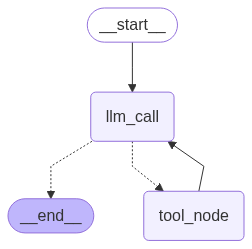

In [13]:
# Import organization: Additional components for persistent memory
from langgraph.store.base import BaseStore
from langgraph.checkpoint.memory import InMemorySaver

def tool_node_persistent(state: ScratchpadState, store: BaseStore) -> dict:
    """Execute tool calls with persistent memory storage across threads.
    
    This version of the tool node uses LangGraph's persistent store to
    maintain scratchpad data across different conversation threads, enabling
    true long-term memory functionality.
    
    Args:
        state: Current conversation state with tool calls
        store: Persistent store for cross-thread memory
        
    Returns:
        Dictionary with tool results
    """
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        
        if tool_call["name"] == "WriteToScratchpad":
            # Save to persistent store for cross-thread access
            notes = observation.notes
            result.append(ToolMessage(content=f"Wrote to scratchpad: {notes}", tool_call_id=tool_call["id"]))
            store.put(namespace, "scratchpad", {"scratchpad": notes})
            update = {"messages": result}
            
        elif tool_call["name"] == "ReadFromScratchpad":
            # Retrieve from persistent store across threads
            stored_data = store.get(namespace, "scratchpad")
            notes = stored_data.value["scratchpad"] if stored_data else "No notes found"
            result.append(ToolMessage(content=f"Notes from scratchpad: {notes}", tool_call_id=tool_call["id"]))
            update = {"messages": result}
            
        elif tool_call["name"] == "tavily_search":
            # Write search tool observation to messages
            result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
            update = {"messages": result}

    return update

# Build persistent memory workflow - enhanced version of the previous workflow
agent_builder_persistent = StateGraph(ScratchpadState)

# Add nodes (reusing llm_call, but with persistent tool node)
agent_builder_persistent.add_node("llm_call", llm_call)
agent_builder_persistent.add_node("tool_node", tool_node_persistent)

# Define workflow edges (same structure as basic version)
agent_builder_persistent.add_edge(START, "llm_call")
agent_builder_persistent.add_conditional_edges("llm_call", should_continue, {"tool_node": "tool_node", END: END})
agent_builder_persistent.add_edge("tool_node", "llm_call")

# Compile with checkpointer for thread-based state persistence
checkpointer = InMemorySaver()

# Initialize persistent memory storage component
memory_store = InMemoryStore()

# Compile with both checkpointer (for thread persistence) and store (for cross-thread memory)
agent = agent_builder_persistent.compile(checkpointer=checkpointer, store=memory_store)

# Display the enhanced workflow graph
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [76]:
#  Research request
config = {"configurable": {"thread_id": "1"}}
state = agent.invoke({
    "messages": [HumanMessage(content="Can you search for funding rounds and recent developments of Commonwealth Fusion Systems?")]
}, config)

from utils import format_messages
console.print("\n[bold cyan]Workflow Result (Thread 1) - Kick Off Research:[/bold cyan]")
format_messages(state['messages'])

Workflow Result (Thread 1) - Kick Off Research:

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Can you search for funding rounds and recent developments of Commonwealth Fusion Systems?                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you research funding rounds and recent developments for Commonwealth Fusion Systems. Let me start by  │
│ checking my scratchpad and then conducting a comprehensive search.                                              │
│                                                                                                                 │
│ 🔧 Tool Call: ReadFromScratchpad                                                                                │
│    Args: {                                                                                                      │
│   "reasoning": "Checking if I have any previous research on Commonwealth Fusion Systems or fusion energy        │
│ companies that could inform my research plan"                                                                   │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Notes from scratchpad: No notes found                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: WriteToScratchpad                                                                                 │
│    Args: {                                                                                                      │
│   "notes": "Research Plan: Commonwealth Fusion Systems (CFS) - Funding and Recent Developments\n\nCompany       │
│ Background:\n- CFS is a nuclear fusion energy company spun out of MIT\n- Focus on developing commercial fusion  │
│ power using high-temperature superconducting magnets\n- Working on SPARC tokamak reactor and ARC commercial     │
│ reactor\n\nResearch Objectives:\n1. Recent funding rounds (2023-2024)\n   - Series B, C, or later funding\n   - │
│ Investment amounts and valuations\n   - Key investors and strategic partners\n\n2. Recent developments          │
│ (2023-2024)\n   - Technical milestones and breakthroughs\n   - Facility expansions or new locations\n   -       │
│ Partnerships and collaborations\n   - Regulatory approvals or permits\n   - Executive changes or key            │
│ hires\n\n3. Market context\n   - Competition in fusion energy space\n   - Industry trends and government        │
│ support\n\nSearch Strategy:\n- Start with recent funding news\n- Follow with general company developments\n-    │
│ Look for technical achievements and milestones"                                                                 │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: Research Plan: Commonwealth Fusion Systems (CFS) - Funding and Recent Developments         │
│                                                                                                                 │
│ Company Background:                                                                                             │
│ - CFS is a nuclear fusion energy company spun out of MIT                                                        │
│ - Focus on developing commercial fusion power using high-temperature superconducting magnets                    │
│ - Working on SPARC tokamak reactor and ARC commercial reactor                                                   │
│                                                                                                                 │
│ Research Objectives:                                                                                            │
│ 1. Recent funding rounds (2023-2024)                                                                            │
│    - Series B, C, or later funding                                                                              │
│    - Investment amounts and valuations                                                                          │
│    - Key investors and strategic partners                                                                       │
│                                                                                                                 │
│ 2. Recent developments (2023-2024)                                                                              │
│    - Technical milestones and breakthroughs                                                                     │
│    - Facility expansions or new locations                                                                       │
│    - Partnerships and collaborations                                                                            │
│    - Regulatory approvals or permits                                                                            │
│    - Executive changes or key hires                                                                             │
│                                                                                                                 │
│ 3. Market context                                                                                               │
│    - Competition in fusion energy space                                                                         │
│    - Industry trends and government support                                                                     │
│                                                                                                                 │
│ Search Strategy:                                                                                                │
│ - Start with recent funding news                                                                                │
│ - Follow with general company developments                                                                      │
│ - Look for technical achievements and milestones                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me search for recent funding information about Commonwealth Fusion Systems:                             │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Commonwealth Fusion Systems funding round investment 2024 2023 Series B Series C",                  │
│   "search_depth": "advanced",                                                                                   │
│   "topic": "finance",                                                                                           │
│   "time_range": "year"                                                                                          │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Commonwealth Fusion Systems funding round investment 2024 2023 Series B Series C',                   │
│ 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':                                  │
│ 'https://www.fusionenergybase.com/organizations/commonwealth-fusion-systems', 'title': 'Commonwealth Fusion     │
│ Systems (CFS) | Fusion Energy Base', 'content': 'AnnouncementSeries A\n\nFunding Received                       │
│ (Nondilutive)\n==============================\n\n### September 27, 2024\n\nprogram                              │
│ CHADWICK\n\n$2,500,000\n\nFundersAdvanced Research Projects Agency-Energy (ARPA-E)\n\nAnnouncementCHADWICK:     │
│ Co-Optimization of an Integral, Layered Materials Solution for Compact Tokamak Vessels\n\n### August 8,         │
│ 2024\n\nprogram INFUSE\n\nFundersFusion Energy Sciences (FES)\n\nAnnouncementINFUSE: Elemental Analysis of      │
│ Fluoride Molten Salt Using Laser Induced Breakdown Spectroscopy (LIBS) [...] Supply Chain                       │
│ Offerings\n======================\n\nSupply chain category\n\nHigh Temperature Superconductor (HTS)             │
│ Magnets\n\nProjects Supplied\n=================\n\n### WHAM 2024 - Present Supply Chain Category High           │
│ Temperature Superconductor (HTS) Magnets Description[Commonwealth Fusion Systems has provided two HTS magnets   │
│ for the WHAM experiment. These are the strongest magnets ever used in a magnetic mirror                         │
│ configuration.](\n\nFunding Received (Investment)\n============================= [...] ### August 8,            │
│ 2024\n\nprogram INFUSE\n\nFundersFusion Energy Sciences (FES)\n\nAnnouncementINFUSE: SOLPS-derived separatrix   │
│ operating space scalings for informing power exhaust scenarios\n\n### July 25, 2023\n\nprogram                  │
│ INFUSE\n\nFundersFusion Energy Sciences (FES)\n\nAnnouncementINFUSE: Informing ARC divertor design and plasma   │
│ facing material selection through integrated modeling\n\n### July 25, 2023\n\nprogram INFUSE\n\nFundersFusion   │
│ Energy Sciences (FES)', 'score': 0.7395922, 'raw_content': None}, {'url':                                       │
│ 'https://www.reddit.com/r/fusion/comments/1km2g7h/commonwealth_fusion_systems_raising_1_billionplus/', 'title': │
│ 'Commonwealth Fusion Systems raising $1 billion-plus Series B2', 'content': 'Image 22: r/fusion icon r/fusion•4 │
│ mo. ago Image 23: A banner for the subreddit Image 24: r/fusion iconr/fusion \nDiscussion and news on           │
│ advancements in the field of nuclear fusion energy and related technologies.\n\n  \n\n31K Members Online    ### │
│ An Update from Commonwealth Fusion Systems (December 2024)  Image 25: r/fusion - An Update from Commonwealth    │
│ Fusion Systems (December 2024)youtu    74 upvotes ·18 comments [...] Update on StockTwits Growth Mission as of  │
│ 12/27/2024Image 92: r/KenduInu_Ecosystem icon r/KenduInu_Ecosystem•5 mo. ago Image 93: A banner for the         │
│ subreddit Image 94: r/KenduInu_Ecosystem iconr/KenduInu_Ecosystem \nKendu is the narrative, and you are the     │
│ catalyst. Become the main character in the rise of the ultimate memecoin ecosystem. Will you join the pack?\n\n │
│ \n\n5.6K Members Online    ### Update on StockTwits Growth Mission as of 12/27/2024    89 upvotes ·7 comments   │
│ [...] Temporal Raises $146M Series C to Power the Future of Durable Applications - Temporalr/tomorrowsworld•1   │
│ mo. ago r/tomorrowsworld \nThe future of the world\n\n  \n\n4.8K Members Online    ### Temporal Raises $146M    │
│ Series C to Power the Future of Durable Applications - Temporal  Image 84: r/tomorrowsworld - Temporal Raises   │
│ $146M Series C to Power the Future of Durable Applications - Temporalgoogle    1 upvote', 'score': 0.57035583,  │
│ 'raw_content': None}, {'url': 'https://neutronbytes.com

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: WriteToScratchpad                                                                                 │
│    Args: {                                                                                                      │
│   "notes": "FUNDING FINDINGS - Commonwealth Fusion Systems:\n\nKey Funding Information:\n- CFS has raised over  │
│ $2 billion in total funding since founding in 2018\n- Currently raising $1 billion+ Series B2 round (as of 4    │
│ months ago per Reddit post)\n- Major investors include: Google, Temasek Holdings, Eni, Bill Gates\n- Recognized │
│ as having raised the most funding of any fusion company in the US\n- According to S&P Global (July 2025), CFS   │
│ is #1 by investment in fusion space, followed by TAE Technologies and Helion\n\nGovernment Funding:\n-          │
│ September 27, 2024: $2.5M from ARPA-E for CHADWICK program\n- August 8, 2024: INFUSE program funding from       │
│ Fusion Energy Sciences (FES)\n- July 25, 2023: Additional INFUSE program funding\n\nRecent Major                │
│ Development:\n- December 17, 2024: Announced world's first commercial fusion power plant location in            │
│ Virginia\n\nNeed to search for more specific recent developments and technical milestones."                     │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: FUNDING FINDINGS - Commonwealth Fusion Systems:                                            │
│                                                                                                                 │
│ Key Funding Information:                                                                                        │
│ - CFS has raised over $2 billion in total funding since founding in 2018                                        │
│ - Currently raising $1 billion+ Series B2 round (as of 4 months ago per Reddit post)                            │
│ - Major investors include: Google, Temasek Holdings, Eni, Bill Gates                                            │
│ - Recognized as having raised the most funding of any fusion company in the US                                  │
│ - According to S&P Global (July 2025), CFS is #1 by investment in fusion space, followed by TAE Technologies    │
│ and Helion                                                                                                      │
│                                                                                                                 │
│ Government Funding:                                                                                             │
│ - September 27, 2024: $2.5M from ARPA-E for CHADWICK program                                                    │
│ - August 8, 2024: INFUSE program funding from Fusion Energy Sciences (FES)                                      │
│ - July 25, 2023: Additional INFUSE program funding                                                              │
│                                                                                                                 │
│ Recent Major Development:                                                                                       │
│ - December 17, 2024: Announced world's first commercial fusion power plant location in Virginia                 │
│                                                                                                                 │
│ Need to search for more specific recent developments and technical milestones.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me search for more recent developments and technical milestones:                                        │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Commonwealth Fusion Systems SPARC tokamak 2024 developments milestones Virginia power plant",       │
│   "search_depth": "advanced",                                                                                   │
│   "time_range": "year"                                                                                          │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Commonwealth Fusion Systems SPARC tokamak 2024 developments milestones Virginia power plant',        │
│ 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':                                  │
│ 'https://cfs.energy/news-and-media/commonwealth-fusion-systems-to-build-worlds-first-commercial-fusion-power-pl │
│ ant-in-virginia/', 'title': "Commonwealth Fusion Systems to Build World's First Commercial ...", 'content':     │
│ 'Devens, Massachusetts (Dec. 17, 2024) – Commonwealth Fusion Systems (CFS), the largest private fusion company, │
│ today announced that it will build the world’s first grid-scale commercial fusion power plant at the James      │
│ River Industrial Park in Chesterfield County, Virginia. [...] 12.17.2024\nCommonwealth Fusion Systems to Build  │
│ World’s First Commercial Fusion Power Plant in                                                                  │
│ Virginia\n============================================================================================\n\nImage │
│ 1: CFS ARC Power Plant viewed from the front [...] The new ARC fusion power plant will support economic         │
│ development and the clean energy goals of Virginia. The project is expected to generate billions of dollars in  │
│ economic development in the region and create hundreds of jobs during the construction and long-term operation  │
│ of the power plant. ARC will generate about 400 megawatts of electricity — enough energy to power large         │
│ industrial sites or about 150,000 homes.', 'score': 0.78749067, 'raw_content': None}, {'url':                   │
│ 'https://www.youtube.com/watch?v=4WCLcmjFYiw&pp=0gcJCfwAo7VqN5tD', 'title': 'An Update from Commonwealth Fusion │
│ Systems (December 2024)', 'content': 'Here’s the look from inside CFS at what else has happened in the past six │
│ months. We have:\n\n- Completed the manufacture of more than half of the toroidal field (TF) magnet “pancakes”  │
│ we need for our first tokamak, SPARC\n- Begun making our first poloidal field (PF) magnet, a pulsed-power       │
│ design\n- Finished manufacturing and testing our Central Solenoid Model Coil (CSMC) magnet, proving out our     │
│ pulsed magnet technology [...] The next step is assembling the SPARC tokamak, our first fusion machine. Two     │
│ orange stands in Tokamak Hall await the first TF magnets, and supporting subsystems for heating, power, and     │
│ cooling are rapidly arriving in the building around Tokamak Hall.\n\nWe’re also sharing some first or early     │
│ looks at new hardware, including of our magnet-testing cryostats and one of our welding robots in action. [...] │
│ 2024 was a big year for CFS. Stay tuned as SPARC’s fusion hardware comes together in                            │
│ 2025.\n------------------------------------------------------------------------------------', 'score':          │
│ 0.7783298, 'raw_content': None}, {'url':                                                                        │
│ 'https://blog.cfs.energy/cfs-will-build-its-first-arc-fusion-power-plant-in-virginia/', 'title': 'CFS will      │
│ build its first ARC fusion power plant in Virginia', 'content': "Commonwealth Fusion Systems\n\n# CFS will      │
│ build its first ARC fusion power plant in Virginia\n\nDecember 17, 2024by Bob Mumgaard\n\nCopy                  │
│ Link\nX\nLinkedIn\nEmail\n\nVirginia is for fusion lovers. [...] The company is deep into building SPARC, a     │
│ machine called a tokamak that’ll demonstrate net fusion energy, a milestone called Q>1. Our next act is         │
│ financing, building, owning, and operating the ARC power plant — a big step after that to deliver fusion        │
│ energy’s promise. Fusion is the last energy source humanity needs, with cheap and abundant fuel, inherently     │
│ safe operations, and no greenhouse gas emissions. Now A

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more specific technical achievements and partnerships:                                        │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "\"Commonwealth Fusion Systems\" magnet testing CSMC model coil 2024 achievements partnerships",     │
│   "search_depth": "advanced",                                                                                   │
│   "time_range": "year"                                                                                          │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': '"Commonwealth Fusion Systems" magnet testing CSMC model coil 2024 achievements partnerships',        │
│ 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':                                  │
│ 'https://www.prnewswire.com/news-releases/commonwealth-fusion-systems-magnet-success-propels-fusion-energy-towa │
│ rd-the-grid-302308013.html', 'title': 'Commonwealth Fusion Systems Magnet Success ... - PR Newswire',           │
│ 'content': 'DEVENS, Mass., Nov. 18, 2024 /PRNewswire/ -- Commonwealth Fusion Systems (CFS) announced today it   │
│ successfully built and tested a record-breaking electromagnet called the Central Solenoid Model Coil (CSMC), a  │
│ major step on the company\'s path to bring clean, abundant fusion power to the grid. [...] Commonwealth Fusion  │
│ Systems Logo (PRNewsfoto/Commonwealth Fusion Systems)")\n\n## News provided by\n\nNov 18, 2024, 08:00 ET\n\n##  │
│ Share this article\n\nShare this article\n\nThe CSMC test shows the company can design, build, and operate both │
│ of its foundational electromagnet technologies needed to build its SPARC fusion machine. [...] The CSMC cements │
│ CFS\' magnet leadership, showing the company\'s ability to establish its HTS supply, manufacture PIT VIPER      │
│ cables at scale, design and validate the CSMC systems over a 45-experiment campaign, and operate it under       │
│ SPARC-like conditions. CFS can now confidently scale up CS and PF magnet manufacturing.\n\nCSMC test results    │
│ included:', 'score': 0.8763069, 'raw_content': None}, {'url':                                                   │
│ 'https://cfs.energy/news-and-media/commonwealth-fusion-systems-magnet-success-propels-fusion-energy-toward-the- │
│ grid/', 'title': 'Commonwealth Fusion Systems Magnet Success Propels Fusion ...', 'content': 'Commonwealth      │
│ Fusion Systems\n\n# Commonwealth Fusion Systems Magnet Success Propels Fusion Energy Toward the Grid\n\nCentral │
│ solenoid model coil (CSMC) at Commonwealth Fusion Systems (CFS)\n\nDEVENS, Mass., November 18, 2024 â\x80\x94   │
│ Commonwealth Fusion Systems (CFS) announced today it successfully built and tested a record-breaking            │
│ electromagnet called the Central Solenoid Model Coil (CSMC), a major step on the companyâ\x80\x99s path to      │
│ bring clean, abundant fusion power to the grid. [...] Commonwealth Fusion Systems is the worldâ\x80\x99s        │
│ leading and largest private fusion company. The companyâ\x80\x99s marquee fusion project, SPARC, will generate  │
│ net energy, paving the way for limitless carbon-free energy. The company has raised more than $2 billion in     │
│ capital since it was founded in 2018.\n\n## Join the power movement\n\nFollow Us\n\nCommonwealth Fusion Systems │
│ \n117 Hospital Rd  \nDevens, MA 01434  \n  \nCopyright 2024 Commonwealth Fusion Systems  \nAll rights reserved  │
│ [...] The CSMC cements CFSâ\x80\x99 magnet leadership, showing the companyâ\x80\x99s ability to establish its   │
│ HTS supply, manufacture PIT VIPER cables at scale, design and validate the CSMC systems over a 45-experiment    │
│ campaign, and operate it under SPARC-like conditions. CFS can now confidently scale up CS and PF magnet         │
│ manufacturing.\n\nCSMC test results included:', 'score': 0.8700796, 'raw_content': None}, {'url':               │
│ 'https://www.youtube.com/watch?v=4WCLcmjFYiw&pp=0gcJCfwAo7VqN5tD', 'title': 'An Update from Commonwealth Fusion │
│ Systems (December 2024)', 'content': "Here’s the look from inside CFS at what else has happened in the past six │
│ months. We have:\n\n- Completed the manufacture of more than half of the toroidal field (TF) magnet “pancakes”  │
│ we need for our first tokamak, SPARC\n- Begun making our first poloidal field (PF) magnet, a pulsed-power       │
│ design\n- Finished manufacturing and testing our Centra

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: WriteToScratchpad                                                                                 │
│    Args: {                                                                                                      │
│   "notes": "RECENT DEVELOPMENTS UPDATE - Commonwealth Fusion Systems:\n\nMajor Technical Achievements in        │
│ 2024:\n\n1. Central Solenoid Model Coil (CSMC) Success (November 18, 2024):\n   - Successfully built and tested │
│ record-breaking electromagnet\n   - Completed 45-experiment campaign under SPARC-like conditions\n   - Proved   │
│ out pulsed magnet technology - described as \"the last outstanding big piece of technology demonstration needed │
│ for SPARC\"\n   - Performed flawlessly, cementing CFS' magnet leadership\n\n2. PIT VIPER Cable Technology       │
│ (October 30, 2024):\n   - Detailed breakthrough superconducting cable technology\n   - Second foundational      │
│ electromagnet technology for compact fusion plants\n   - Exceeded all expectations in testing\n   - Over 4      │
│ kilometers of PIT VIPER cable fabricated\n\n3. SPARC Construction Progress (December 2024):\n   - Completed     │
│ manufacture of more than half of toroidal field (TF) magnet \"pancakes\"\n   - Begun making first poloidal      │
│ field (PF) magnet\n   - Two orange stands in Tokamak Hall await first TF magnets\n   - Supporting subsystems    │
│ for heating, power, and cooling rapidly arriving\n   - SPARC facility becoming \"hub of activity\"\n   -        │
│ Target: First net energy production in 2027\n\n4. Commercial Power Plant Announcement (December 17, 2024):\n    │
│ - World's first grid-scale commercial fusion power plant in Virginia\n   - Location: James River Industrial     │
│ Park, Chesterfield County\n   - ARC power plant will generate ~400 MW (enough for 150,000 homes)\n   - Target:  │
│ Power to grid by early 2030s\n   - Expected to create hundreds of jobs and billions in economic                 │
│ development\n\n5. Strategic Partnerships:\n   - Partnership with Type One Energy for superconducting magnets\n  │
│ - Supplied HTS magnets for University of Wisconsin's WHAM experiment\n   - Continued collaboration with MIT"    │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: RECENT DEVELOPMENTS UPDATE - Commonwealth Fusion Systems:                                  │
│                                                                                                                 │
│ Major Technical Achievements in 2024:                                                                           │
│                                                                                                                 │
│ 1. Central Solenoid Model Coil (CSMC) Success (November 18, 2024):                                              │
│    - Successfully built and tested record-breaking electromagnet                                                │
│    - Completed 45-experiment campaign under SPARC-like conditions                                               │
│    - Proved out pulsed magnet technology - described as "the last outstanding big piece of technology           │
│ demonstration needed for SPARC"                                                                                 │
│    - Performed flawlessly, cementing CFS' magnet leadership                                                     │
│                                                                                                                 │
│ 2. PIT VIPER Cable Technology (October 30, 2024):                                                               │
│    - Detailed breakthrough superconducting cable technology                                                     │
│    - Second foundational electromagnet technology for compact fusion plants                                     │
│    - Exceeded all expectations in testing                                                                       │
│    - Over 4 kilometers of PIT VIPER cable fabricated                                                            │
│                                                                                                                 │
│ 3. SPARC Construction Progress (December 2024):                                                                 │
│    - Completed manufacture of more than half of toroidal field (TF) magnet "pancakes"                           │
│    - Begun making first poloidal field (PF) magnet                                                              │
│    - Two orange stands in Tokamak Hall await first TF magnets                                                   │
│    - Supporting subsystems for heating, power, and cooling rapidly arriving                                     │
│    - SPARC facility becoming "hub of activity"                                                                  │
│    - Target: First net energy production in 2027                                                                │
│                                                                                                                 │
│ 4. Commercial Power Plant Announcement (December 17, 2024):                                                     │
│    - World's first grid-scale commercial fusion power plant in Virginia                                         │
│    - Location: James River Industrial Park, Chesterfield County                                                 │
│    - ARC power plant will generate ~400 MW (enough for 150,000 homes)                                           │
│    - Target: Power to grid by early 2030s                                                                       │
│    - Expected to create hundreds of jobs and billions in economic development                                   │
│                                                                                                                 │
│ 5. Strategic Partnerships:                                                                                      │
│    - Partnership with Type One Energy for superconducti

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for any additional recent funding details or executive changes:                                   │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "\"Commonwealth Fusion Systems\" Series B2 funding investors 2024 executive leadership changes",     │
│   "search_depth": "advanced",                                                                                   │
│   "time_range": "year"                                                                                          │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': '"Commonwealth Fusion Systems" Series B2 funding investors 2024 executive leadership changes',        │
│ 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':                                  │
│ 'https://www.reddit.com/r/fusion/comments/1km2g7h/commonwealth_fusion_systems_raising_1_billionplus/', 'title': │
│ 'Commonwealth Fusion Systems raising $1 billion-plus Series B2', 'content': 'Image 22: r/fusion icon r/fusion•4 │
│ mo. ago Image 23: A banner for the subreddit Image 24: r/fusion iconr/fusion \nDiscussion and news on           │
│ advancements in the field of nuclear fusion energy and related technologies.\n\n  \n\n31K Members Online    ### │
│ An Update from Commonwealth Fusion Systems (December 2024)  Image 25: r/fusion - An Update from Commonwealth    │
│ Fusion Systems (December 2024)youtu    74 upvotes ·18 comments [...] Update on StockTwits Growth Mission as of  │
│ 12/27/2024Image 92: r/KenduInu_Ecosystem icon r/KenduInu_Ecosystem•5 mo. ago Image 93: A banner for the         │
│ subreddit Image 94: r/KenduInu_Ecosystem iconr/KenduInu_Ecosystem \nKendu is the narrative, and you are the     │
│ catalyst. Become the main character in the rise of the ultimate memecoin ecosystem. Will you join the pack?\n\n │
│ \n\n5.6K Members Online    ### Update on StockTwits Growth Mission as of 12/27/2024    89 upvotes ·7 comments   │
│ [...] 31K Members Online    ### General Fusion lays off staff due to ‘unexpected and urgent financing           │
│ constraints’  Image 30: r/fusion - General Fusion lays off staff due to ‘unexpected and urgent financing        │
│ constraints’physicsworld    40 upvotes ·8 comments', 'score': 0.66464967, 'raw_content': None}, {'url':         │
│ 'https://cfs.energy/devens-campus/updates/', 'title': 'Devens Events & Updates - Commonwealth Fusion Systems',  │
│ 'content': 'Jan 05, 2024\n\nAn Update from Commonwealth Fusion Systems\n\nThis is the second video in a series  │
│ of the latest updates from inside CFS. In this episode, CEO Bob Mumgaard and VP of Production Darby Dunn share  │
│ major milestones CFS has achieved since June 2023 that have helped to accelerate our path to commercial fusion. │
│ [...] We hope you can join us for a reception with team members fromÂ Electric HydrogenÂ andÂ Commonwealth      │
│ Fusion SystemsÂ followed by a panel discussion on the Devens ecosystem with Scott Jansen, Vice President of     │
│ Manufacturing at Electric Hydrogen, Tyson Reynoso, Managing Director & Partner at King Street Properties, and   │
│ Jessica Strunkin, Principal for Community Relations and Local Government Affairs at Commonwealth Fusion         │
│ Systems.\n\nMar 21, 2024 [...] Commonwealth Fusion Systems (CFS) has closed on more than $1.8 billion in Series │
│ B funding to commercialize fusion energy. This includes capital to construct, commission, and operate SPARC,    │
│ the worldâ\x80\x99s first commercially relevant net energy fusion machine at Devens. In addition, it will       │
│ enable the company to begin work on ARC, the first commercial fusion power plant, which includes developing     │
│ support technologies, advancing the design, identifying the site, and assembling the partners and', 'score':    │
│ 0.60861784, 'raw_content': None}, {'url':                                                                       │
│ 'https://www.axios.com/pro/climate-deals/2025/05/13/commonwealth-fusion-systems-b2-fundraise-arc', 'title':     │
│ 'Commonwealth Fusion Systems raising $1 billion-plus Series B2', 'content': "Google and Microsoft co-founder    │
│ Bill Gates are investors in Commonwealth Fusion.\n   Microsoft declined to comment; Google did not return a     │
│ request for comment.\n\nThe big picture: Commonwealth Fusion is perhaps the most prominent and well-funded      │
│ startup in climate tech, pursuing an energy source that

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: WriteToScratchpad                                                                                 │
│    Args: {                                                                                                      │
│   "notes": "FINAL FUNDING UPDATE - Commonwealth Fusion Systems:\n\nSeries B Funding Details:\n- Closed more     │
│ than $1.8 billion in Series B funding (as of March 2024)\n- Currently raising Series B2 extension targeting $1  │
│ billion to $1.5 billion\n- A hyperscale data center developer is anchoring the Series B2 raise\n- Total funding │
│ now exceeds $2 billion since 2018 founding\n- Major investors include: Google, Microsoft co-founder Bill Gates, │
│ Temasek Holdings, Eni\n\nKey Leadership:\n- CEO: Bob Mumgaard (Co-founder)\n- Chief Science Officer: Brandon    │
│ Sorbom\n- VP of Production: Darby Dunn\n- Principal for Community Relations: Jessica Strunkin\n\nTimeline       │
│ Summary:\n- 2026: SPARC expected to produce first plasma\n- 2027: SPARC target for first net energy production  │
│ (Q>1)\n- Early 2030s: ARC commercial power plant to deliver power to grid in Virginia\n\nCompany Status:\n-     │
│ World's largest private fusion company\n- Most well-funded fusion startup globally\n- Leading position in       │
│ fusion energy sector by investment"                                                                             │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: FINAL FUNDING UPDATE - Commonwealth Fusion Systems:                                        │
│                                                                                                                 │
│ Series B Funding Details:                                                                                       │
│ - Closed more than $1.8 billion in Series B funding (as of March 2024)                                          │
│ - Currently raising Series B2 extension targeting $1 billion to $1.5 billion                                    │
│ - A hyperscale data center developer is anchoring the Series B2 raise                                           │
│ - Total funding now exceeds $2 billion since 2018 founding                                                      │
│ - Major investors include: Google, Microsoft co-founder Bill Gates, Temasek Holdings, Eni                       │
│                                                                                                                 │
│ Key Leadership:                                                                                                 │
│ - CEO: Bob Mumgaard (Co-founder)                                                                                │
│ - Chief Science Officer: Brandon Sorbom                                                                         │
│ - VP of Production: Darby Dunn                                                                                  │
│ - Principal for Community Relations: Jessica Strunkin                                                           │
│                                                                                                                 │
│ Timeline Summary:                                                                                               │
│ - 2026: SPARC expected to produce first plasma                                                                  │
│ - 2027: SPARC target for first net energy production (Q>1)                                                      │
│ - Early 2030s: ARC commercial power plant to deliver power to grid in Virginia                                  │
│                                                                                                                 │
│ Company Status:                                                                                                 │
│ - World's largest private fusion company                                                                        │
│ - Most well-funded fusion startup globally                                                                      │
│ - Leading position in fusion energy sector by investment                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my comprehensive research, here's a detailed overview of Commonwealth Fusion Systems' funding rounds   │
│ and recent developments:                                                                                        │
│                                                                                                                 │
│ ## **Funding Rounds & Financial Status**                                                                        │
│                                                                                                                 │
│ ### **Major Private Funding**                                                                                   │
│ - **Total Raised**: Over $2 billion since founding in 2018                                                      │
│ - **Series B**: Closed more than $1.8 billion (as of March 2024)                                                │
│ - **Series B2 (Ongoing)**: Currently raising $1 billion to $1.5 billion extension                               │
│   - A hyperscale data center developer is anchoring this round                                                  │
│   - Signals strong tech industry interest in fusion energy                                                      │
│                                                                                                                 │
│ ### **Key Investors**                                                                                           │
│ - Google                                                                                                        │
│ - Bill Gates (Microsoft co-founder)                                                                             │
│ - Temasek Holdings                                                                                              │
│ - Eni (Italian energy company)                                                                                  │
│                                                                                                                 │
│ ### **Government Funding (2024)**                                                                               │
│ - **September 2024**: $2.5M from ARPA-E for CHADWICK program                                                    │
│ - **August 2024**: INFUSE program funding from Fusion Energy Sciences (FES)                                     │
│                                                                                                                 │
│ ## **Recent Major Developments (2024)**                                                                         │
│                                                                                                                 │
│ ### **Technical Breakthroughs**                                                                                 │
│                                                                                                                 │
│ 1. **Central Solenoid Model Coil (CSMC) Success** (November 18, 2024)                                           │
│    - Successfully tested record-breaking electromagnet                                                          │
│    - Completed 45-experiment campaign under SPARC-like conditions                                               │
│    - Described as "the last outstanding big piece of technology demonstration needed for SPARC"                 │
│    - Performed flawlessly, proving out pulsed magnet technology                                                 │
│                                                                                                                 │
│ 2. **PIT VIPER Cable Technology** (October 30, 2024)                                                            │
│    - Breakthrough superconducting cable technology deta

Here is the [trace](https://smith.langchain.com/public/ca39ff80-36b1-4670-be55-22c3fd5b3bfd/r) for this run.

Now, let's start a new conversation and see if the agent can access the scratchpad from the previous conversation.

In [77]:
# Cross-thread memory persistence demonstration
config_2 = {"configurable": {"thread_id": "2"}}
messages_2 = agent.invoke({
    "messages": [HumanMessage(content="How does the funding raised for Helion Energy compare to Commonwealth Fusion Systems?")]
}, config_2)

console.print("\n[bold cyan]Workflow Result (Thread 2) - Cross-Thread Memory Access:[/bold cyan]")
format_messages(messages_2['messages'])

Workflow Result (Thread 2) - Cross-Thread Memory Access:

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ How does the funding raised for Helion Energy compare to Commonwealth Fusion Systems?                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you compare the funding raised by Helion Energy and Commonwealth Fusion Systems. Let me start by      │
│ checking my scratchpad and then conducting research on both companies.                                          │
│                                                                                                                 │
│ 🔧 Tool Call: ReadFromScratchpad                                                                                │
│    Args: {                                                                                                      │
│   "reasoning": "Checking if I have any previous research on Helion Energy or Commonwealth Fusion Systems        │
│ funding information"                                                                                            │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Notes from scratchpad: FINAL FUNDING UPDATE - Commonwealth Fusion Systems:                                      │
│                                                                                                                 │
│ Series B Funding Details:                                                                                       │
│ - Closed more than $1.8 billion in Series B funding (as of March 2024)                                          │
│ - Currently raising Series B2 extension targeting $1 billion to $1.5 billion                                    │
│ - A hyperscale data center developer is anchoring the Series B2 raise                                           │
│ - Total funding now exceeds $2 billion since 2018 founding                                                      │
│ - Major investors include: Google, Microsoft co-founder Bill Gates, Temasek Holdings, Eni                       │
│                                                                                                                 │
│ Key Leadership:                                                                                                 │
│ - CEO: Bob Mumgaard (Co-founder)                                                                                │
│ - Chief Science Officer: Brandon Sorbom                                                                         │
│ - VP of Production: Darby Dunn                                                                                  │
│ - Principal for Community Relations: Jessica Strunkin                                                           │
│                                                                                                                 │
│ Timeline Summary:                                                                                               │
│ - 2026: SPARC expected to produce first plasma                                                                  │
│ - 2027: SPARC target for first net energy production (Q>1)                                                      │
│ - Early 2030s: ARC commercial power plant to deliver power to grid in Virginia                                  │
│                                                                                                                 │
│ Company Status:                                                                                                 │
│ - World's largest private fusion company                                                                        │
│ - Most well-funded fusion startup globally                                                                      │
│ - Leading position in fusion energy sector by investment                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Great! I have some information about Commonwealth Fusion Systems already. Now let me create a research plan and │
│ search for current information on both companies' funding.                                                      │
│                                                                                                                 │
│ 🔧 Tool Call: WriteToScratchpad                                                                                 │
│    Args: {                                                                                                      │
│   "notes": "RESEARCH PLAN: Helion Energy vs Commonwealth Fusion Systems Funding Comparison\n\nFrom previous     │
│ research:\n- Commonwealth Fusion Systems: Over $2 billion raised, currently raising Series B2 extension         │
│ ($1-1.5B)\n\nNeed to research:\n1. Helion Energy total funding raised\n2. Helion Energy recent funding rounds   │
│ and investors\n3. Updated Commonwealth Fusion Systems funding (verify current totals)\n4. Direct comparison of  │
│ funding amounts\n5. Context on what these funding levels mean in the fusion industry\n\nSearch Strategy:\n-     │
│ Start with Helion Energy funding information\n- Verify/update Commonwealth Fusion Systems data\n- Look for      │
│ industry comparisons"                                                                                           │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: RESEARCH PLAN: Helion Energy vs Commonwealth Fusion Systems Funding Comparison             │
│                                                                                                                 │
│ From previous research:                                                                                         │
│ - Commonwealth Fusion Systems: Over $2 billion raised, currently raising Series B2 extension ($1-1.5B)          │
│                                                                                                                 │
│ Need to research:                                                                                               │
│ 1. Helion Energy total funding raised                                                                           │
│ 2. Helion Energy recent funding rounds and investors                                                            │
│ 3. Updated Commonwealth Fusion Systems funding (verify current totals)                                          │
│ 4. Direct comparison of funding amounts                                                                         │
│ 5. Context on what these funding levels mean in the fusion industry                                             │
│                                                                                                                 │
│ Search Strategy:                                                                                                │
│ - Start with Helion Energy funding information                                                                  │
│ - Verify/update Commonwealth Fusion Systems data                                                                │
│ - Look for industry comparisons                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Helion Energy funding raised total amount investors 2024",                                          │
│   "search_depth": "advanced"                                                                                    │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Helion Energy funding raised total amount investors 2024', 'follow_up_questions': None, 'answer':    │
│ None, 'images': [], 'results': [{'url':                                                                         │
│ 'https://newatlas.com/energy/helion-1-billion-3-years-fusion-clean-energy/', 'title': 'Helion has $1 billion    │
│ and 3 years to figure out fusion-powered energy', 'content': "Helion has $1 billion and 3 years to figure out   │
│ fusion-powered energy\n\nWashington-based fusion energy company Helion just raised US$425 million in fresh      │
│ funding for its bid to be the first to produce usable electricity through nuclear fusion. The firm's latest     │
│ Series F round brings the total investment into Helion over the $1 billion line, and it's aiming to begin       │
│ delivering power from a single fusion 50-MW plant to Microsoft by 2028. [...] The latest injection of funds     │
│ will be directed towards manufacturing components in-house, including capacitors for energy storage and         │
│ magnetic coils for its prototype fusion reactor. That follows a $500 million round from back in 2021, and it    │
│ should help Helion advance its work building a commercial power plant over the next few years. [...] Helion     │
│ isn't alone in the race to make nuclear fusion a reality. As our own David Szondy noted last July, nearly 50    │
│ privately funded fusion startups in 12 countries are aiming to deliver commercial fusion power by 2030. And     │
│ earlier this week, a Chinese reactor set a new record with a 1,066-second-long fusion reaction.\n\nCracking     │
│ this puzzle could mean a world-changing way to generate abundant clean power, so this is a competition worth    │
│ keeping an eye on.\n\nSource: Helion Energy\n\nTags", 'score': 0.72629017, 'raw_content': None}, {'url':        │
│ 'https://www.helionenergy.com/articles/helion-announces-425m-series-f-investment-to-scale-commercialized-fusion │
│ -power/', 'title': 'Helion Announces $425M Series F Investment to Scale ...', 'content': 'Moskovitz through     │
│ Good Ventures Foundation, and Nucor. This latest round of funding will bring the total invested in Helion to    │
│ over $1 billion and values the company at $5.425 billion post-money. [...] Moskovitz through Good Ventures      │
│ Foundation, and Nucor. This latest round of funding will bring the total invested in Helion to over $1 billion  │
│ and values the company at $5.425 billion post-money. [...] EVERETT, Wash. – January 28, 2025 – Helion, a fusion │
│ energy company, today announced a $425 million Series F investment round that will be used to scale             │
│ commercialization efforts for the company’s groundbreaking fusion technology. The oversubscribed and upsized    │
│ round had participation from new investors, including Lightspeed Venture Partners, SoftBank Vision Fund 2, and  │
│ a major university endowment, and existing investors including Sam Altman, Mithril Capital, Capricorn           │
│ Investment Group, Dustin', 'score': 0.694241, 'raw_content': None}, {'url':                                     │
│ 'https://www.heraldnet.com/news/helion-celebrates-smoother-path-to-fusion-energy-site-approval/', 'title':      │
│ 'Helion celebrates smoother path to fusion energy site approval', 'content': 'Helion received $425 million in   │
│ new funding in January to expand its goal of building nuclear plants using fusion energy.\n\nThe company has    │
│ raised more than $1 billion for its efforts to deliver carbon-free electricity without the drawbacks of         │
│ traditional nuclear power, such as radioactive waste. [...] Positions with three or more candidates will go to  │
│ voters Aug. 5 to determine final contenders for the Nov. 4 general election.\n\nImage 27: Aaron Weinstock uses  │
│ an x-ray machine toy inside the Imagine Children Museum

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: WriteToScratchpad                                                                                 │
│    Args: {                                                                                                      │
│   "notes": "HELION ENERGY FUNDING UPDATE (January 2025):\n\nLatest Funding Round:\n- Series F: $425 million     │
│ (January 28, 2025)\n- Post-money valuation: $5.425 billion\n- Total funding raised: Over $1 billion\n\nKey      │
│ Investors in Series F:\n- Lightspeed Venture Partners (new)\n- SoftBank Vision Fund 2 (new)\n- Major university │
│ endowment (new)\n- Sam Altman (existing)\n- Mithril Capital (existing)\n- Capricorn Investment Group            │
│ (existing)\n- Dustin Moskovitz through Good Ventures Foundation (existing)\n- Nucor (existing)\n\nPrevious      │
│ Major Rounds:\n- Series E (November 2021): $500 million\n- Additional $1.7 billion in commitments tied to       │
│ milestones\n- Early funding: $7M from NASA, DOE, DoD + $1.5M private (2014)\n\nCompany Details:\n- 550          │
│ employees in Everett, Washington\n- Target: Deliver power to Microsoft by 2028 (50-MW plant)\n- Executive       │
│ Chairman: Sam Altman (OpenAI CEO)"                                                                              │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: HELION ENERGY FUNDING UPDATE (January 2025):                                               │
│                                                                                                                 │
│ Latest Funding Round:                                                                                           │
│ - Series F: $425 million (January 28, 2025)                                                                     │
│ - Post-money valuation: $5.425 billion                                                                          │
│ - Total funding raised: Over $1 billion                                                                         │
│                                                                                                                 │
│ Key Investors in Series F:                                                                                      │
│ - Lightspeed Venture Partners (new)                                                                             │
│ - SoftBank Vision Fund 2 (new)                                                                                  │
│ - Major university endowment (new)                                                                              │
│ - Sam Altman (existing)                                                                                         │
│ - Mithril Capital (existing)                                                                                    │
│ - Capricorn Investment Group (existing)                                                                         │
│ - Dustin Moskovitz through Good Ventures Foundation (existing)                                                  │
│ - Nucor (existing)                                                                                              │
│                                                                                                                 │
│ Previous Major Rounds:                                                                                          │
│ - Series E (November 2021): $500 million                                                                        │
│ - Additional $1.7 billion in commitments tied to milestones                                                     │
│ - Early funding: $7M from NASA, DOE, DoD + $1.5M private (2014)                                                 │
│                                                                                                                 │
│ Company Details:                                                                                                │
│ - 550 employees in Everett, Washington                                                                          │
│ - Target: Deliver power to Microsoft by 2028 (50-MW plant)                                                      │
│ - Executive Chairman: Sam Altman (OpenAI CEO)                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me search for the most current information on Commonwealth Fusion Systems to ensure I have the latest   │
│ funding data.                                                                                                   │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Commonwealth Fusion Systems funding raised total 2024 2025 Series B",                               │
│   "search_depth": "advanced"                                                                                    │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'Commonwealth Fusion Systems funding raised total 2024 2025 Series B', 'follow_up_questions': None,   │
│ 'answer': None, 'images': [], 'results': [{'url':                                                               │
│ 'https://www.cfs.energy/news-and-media/commonwealth-fusion-systems-closes-1-8-billion-series-b-round', 'title': │
│ 'Commonwealth Fusion Systems Raises $1.8 Billion in Funding to ...', 'content': 'Commonwealth Fusion Systems    │
│ (CFS) announced it has closed on more than $1.8 billion in Series B funding to commercialize fusion energy.     │
│ This includes capital to construct, commission, and operate SPARC, the world’s first commercially relevant net  │
│ energy fusion machine. In addition, it will enable the company to begin work on ARC, the first commercial       │
│ fusion power plant, which includes developing support technologies, advancing the design, identifying the site, │
│ and assembling the partners and [...] #### Related Topics\n\nfundingcompany news\n\nJoin the power              │
│ movement\n-----------------------\n\nFollow Us\n\n   Image 1\n   Image 2\n   Image 3\n   Image 4\n\nApply       │
│ Now\n\n[](\nCommonwealth Fusion Systems\n\n117 Hospital Rd\n\nDevens, MA 01434\n\nCopyright 2024 Commonwealth   │
│ Fusion Systems\n\nAll rights reserved\n\nMedia & Press\n\npress@cfs.energyGeneral                               │
│ Inquiries\n\ninfo@cfs.energy\n\nJoin our mailing list\n\n   Company\n   Technology\n   Press Releases\n         │
│ Privacy Policy\n   Careers\n   Blog [...] Commonwealth Fusion Systems Raises $1.8 Billion in Funding to         │
│ Commercialize Fusion Energy | Commonwealth Fusion Systems\n\n===============\n\nSkip to content\n\nCommonwealth │
│ Fusion Systems Commonwealth Fusion Systems\n   TechnologyShow submenu for technology↓\n   CompanyShow submenu   │
│ for company↓\n   News & MediaShow submenu for news & media↓\n   LocationsShow submenu for locations↓\n          │
│ Careers', 'score': 0.8464638, 'raw_content': None}, {'url':                                                     │
│ 'https://www.axios.com/pro/climate-deals/2025/05/13/commonwealth-fusion-systems-b2-fundraise-arc', 'title':     │
│ 'Commonwealth Fusion Systems raising $1 billion-plus Series B2', 'content': "Published Time:                    │
│ 2025-05-13T20:02:54.860989Z\n\nCommonwealth Fusion Systems raising $1 billion-plus Series B2\n===============\n │
│ \n\n \n\nManage your consent preferences\n\nWe use cookies and similar methods to recognize visitors and        │
│ remember their preferences. We may also use them to measure ad campaign effectiveness, target ads, and analyze  │
│ site traffic. Depending on your location, you may opt-in or opt out of the use of these technologies.\n\nManage │
│ targeted advertising and similar data sales or sharing [...] Commonwealth Fusion Systems has raised over $1     │
│ billion in extension funding to build its first commercial power system, two sources familiar with the raise    │
│ tell Axios.\n\nWhy it matters: A hyperscale data center developer is anchoring the raise, signaling just how    │
│ seriously tech firms are taking fusion energy.\n\nBy the numbers: Commonwealth Fusion's ongoing Series B2 is    │
│ now targeting between $1 billion and $1.5 billion, the sources tell Axios. [...] Newsletters\n   Axios Live\n   │
│ Axios Entertainment\n   Axios HQ\n\n   Privacy policy\n   Terms of use\n   Your Privacy Choices\n\nAxios        │
│ HomepageAxios Media Inc., 2025\n\n \n\nAxios Pro\n\nExclusive Content\n\nRequest a trial to unlock this         │
│ article\n--------------------------------------\n\nUnlock exclusive reporting across VC, PE and M&A from Axios  │
│ Pro’s industry-leading journalists.", 'score': 0.8095324, 'raw_content': None}, {'url':                         │
│ 'https://www.reddit.com/r/fusion/comments/1km2g7h/commo

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more specific information about Commonwealth Fusion Systems' total funding to get the most    │
│ accurate comparison.                                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "\"Commonwealth Fusion Systems\" total funding raised \"over $2 billion\" Series B2 extension",      │
│   "search_depth": "advanced"                                                                                    │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': '"Commonwealth Fusion Systems" total funding raised "over $2 billion" Series B2 extension',           │
│ 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url':                                  │
│ 'https://www.idtechex.com/en/research-article/google-purchases-200mw-of-fusion-power-from-us-2-billion-startup/ │
│ 33467', 'title': 'Google Purchases 200MW of Fusion Power from US$2 Billion Startup', 'content': 'How CFS plans  │
│ to extract energy from fusion\n\nCommonwealth Fusion Systems, an MIT spinout, has raised over US$2 billion in   │
│ funding to date, and is currently building a fusion prototype facility SPARC in Devens, Massachusetts which     │
│ will validate that net energy can be produced from fusion using their approach. Following SPARC, they plan to   │
│ build ARC, a 400MW power plant, with half of this output now sold to Google. [...] On the 30 th of June 2025,   │
│ Google signed a deal to purchase 200MW of power from Commonwealth Fusion Systems (CFS), who expect their first  │
│ commercial power plant, ARC, to come online in the early 2030s. This announcement shows that fusion is now      │
│ being taken seriously as a source of green, continuous energy, which will be vital in reducing the greenhouse   │
│ gas emissions of data centers and other energy-intensive industries.', 'score': 0.83932644, 'raw_content':      │
│ None}, {'url':                                                                                                  │
│ 'https://carboncredits.com/google-backs-fusion-energy-signs-200mw-offtake-agreement-with-commonwealth-fusion-sy │
│ stems/', 'title': 'Signs 200MW Offtake Agreement with Commonwealth Fusion Systems', 'content': 'Notably, with   │
│ over $2 billion in support from private and public investors, Commonwealth Fusion Systems leads the way toward  │
│ a zero-carbon energy future.\n\nBob Mumgaard, CEO and Co-founder of CFS, said,', 'score': 0.7771143,            │
│ 'raw_content': None}, {'url':                                                                                   │
│ 'https://www.axios.com/pro/climate-deals/2025/05/13/commonwealth-fusion-systems-b2-fundraise-arc', 'title':     │
│ 'Commonwealth Fusion Systems raising $1 billion-plus Series B2', 'content': 'The round, expected to close this  │
│ summer, crested its initial $800 million target after it drew participation from a large hyperscaler, the       │
│ sources say.\n   If it raises more than $1 billion, the valuation would be over $8 billion, which is a major    │
│ uptick from its roughly $5 billion post-money valuation when it raised $1.8 billion in 2021.\n\nZoom in: Both   │
│ sources declined to disclose which data center developer is participating, though both said it\'s a prominent   │
│ tech firm. [...] Rep. Jerry Nadler and then-Speaker Nancy Pelosi at a press conference at the U.S. Capitol on   │
│ Jan. 15, 2020. Photo: OLIVIER DOULIERY/AFP via Getty Images\n\nA rogue Trump impeachment push was criticized as │
│ "idiotic" and "horrible" in a closed-door House Democratic meeting Wednesday, Axios has learned. [...] Health   │
│ Sec. Robert F. Kennedy Jr. testifies before a House panel on May 14 in Washington, DC. Photo: Samuel            │
│ Corum/Getty Images\n\nHealth Secretary Robert F. Kennedy Jr. is testifying on Capitol Hill Wednesday, where     │
│ he\'s been pressed on mass layoffs at the Department of Health and Human Services, billions in cuts to the      │
│ agencies he oversees and the ongoing measles outbreak.', 'score': 0.77650476, 'raw_content': None}, {'url':     │
│ 'https://www.cfs.energy/news-and-media/commonwealth-fusion-systems-closes-1-8-billion-series-b-round', 'title': │
│ 'Commonwealth Fusion Systems Raises $1.8 Billion in Funding to ...', 'content': '"Fusion is the kind of         │
│ innovation that can help fill the gaps in grids and put

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: WriteToScratchpad                                                                                 │
│    Args: {                                                                                                      │
│   "notes": "UPDATED COMMONWEALTH FUSION SYSTEMS FUNDING (2025):\n\nCurrent Status:\n- Total funding raised:     │
│ Over $2 billion since 2018 founding\n- Series B (2021): $1.8 billion closed\n- Series B2 Extension (ongoing):   │
│ Targeting $1-1.5 billion, expected to close summer 2025\n- If Series B2 closes at $1B+, total funding would     │
│ exceed $3 billion\n- Current valuation: ~$5 billion (2021), expected to exceed $8 billion with Series B2\n\nKey │
│ Details:\n- World's largest private fusion company\n- Most well-funded fusion startup globally\n- Major         │
│ partnership: Google signed 200MW power purchase agreement\n- SPARC facility under construction in Devens,       │
│ Massachusetts\n- ARC commercial plant planned for early 2030s\n\nFUNDING COMPARISON SUMMARY:\nHelion Energy:    │
│ Over $1 billion total\nCommonwealth Fusion Systems: Over $2 billion (potentially $3+ billion with Series        │
│ B2)\n\nCFS has raised approximately 2x more funding than Helion Energy"                                         │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: UPDATED COMMONWEALTH FUSION SYSTEMS FUNDING (2025):                                        │
│                                                                                                                 │
│ Current Status:                                                                                                 │
│ - Total funding raised: Over $2 billion since 2018 founding                                                     │
│ - Series B (2021): $1.8 billion closed                                                                          │
│ - Series B2 Extension (ongoing): Targeting $1-1.5 billion, expected to close summer 2025                        │
│ - If Series B2 closes at $1B+, total funding would exceed $3 billion                                            │
│ - Current valuation: ~$5 billion (2021), expected to exceed $8 billion with Series B2                           │
│                                                                                                                 │
│ Key Details:                                                                                                    │
│ - World's largest private fusion company                                                                        │
│ - Most well-funded fusion startup globally                                                                      │
│ - Major partnership: Google signed 200MW power purchase agreement                                               │
│ - SPARC facility under construction in Devens, Massachusetts                                                    │
│ - ARC commercial plant planned for early 2030s                                                                  │
│                                                                                                                 │
│ FUNDING COMPARISON SUMMARY:                                                                                     │
│ Helion Energy: Over $1 billion total                                                                            │
│ Commonwealth Fusion Systems: Over $2 billion (potentially $3+ billion with Series B2)                           │
│                                                                                                                 │
│ CFS has raised approximately 2x more funding than Helion Energy                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive comparison of the funding raised by Helion Energy and Commonwealth │
│ Fusion Systems:                                                                                                 │
│                                                                                                                 │
│ ## Funding Comparison: Helion Energy vs Commonwealth Fusion Systems                                             │
│                                                                                                                 │
│ ### **Commonwealth Fusion Systems (CFS)**                                                                       │
│ - **Total Funding Raised**: Over **$2 billion** since founding in 2018                                          │
│ - **Latest Major Round**: $1.8 billion Series B (closed in 2021)                                                │
│ - **Current Fundraising**: Series B2 extension targeting $1-1.5 billion (expected to close summer 2025)         │
│ - **Potential Total**: Could exceed **$3 billion** if Series B2 closes at target                                │
│ - **Current Valuation**: ~$5 billion (2021), expected to exceed $8 billion with Series B2                       │
│ - **Status**: World's largest private fusion company and most well-funded fusion startup globally               │
│                                                                                                                 │
│ ### **Helion Energy**                                                                                           │
│ - **Total Funding Raised**: Over **$1 billion**                                                                 │
│ - **Latest Round**: $425 million Series F (January 28, 2025)                                                    │
│ - **Previous Major Round**: $500 million Series E (November 2021)                                               │
│ - **Additional Commitments**: $1.7 billion tied to specific milestones                                          │
│ - **Current Valuation**: $5.425 billion post-money (January 2025)                                               │
│                                                                                                                 │
│ ## Key Differences                                                                                              │
│                                                                                                                 │
│ **1. Total Capital Raised**                                                                                     │
│ - Commonwealth Fusion Systems has raised approximately **2x more funding** than Helion Energy                   │
│ - CFS: $2+ billion (potentially $3+ billion)                                                                    │
│ - Helion: $1+ billion                                                                                           │
│                                                                                                                 │
│ **2. Funding Strategy**                                                                                         │
│ - **CFS**: Fewer, larger rounds (massive $1.8B Series B)                                                        │
│ - **Helion**: More frequent rounds with milestone-based commitments                                             │
│                                                                                                                 │
│ **3. Market Position**                                                                                          │
│ - **CFS**: Recognized as the world's largest private fusion company                                             │
│ - **Helion**: Strong position with notable tech industr

Great! We can see from the [trace](https://smith.langchain.com/public/289608bd-3029-436a-ac9a-0b1103b5cc53/r) that we can access the scratchpad from the previous conversation.